<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - First predictions at 3h
<!-- DESC --> Episode 2 : Learning session and weather prediction attempt at 3h
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : SYNOP2
Run time             : Monday 01 March 2021, 20:30:08
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset
#
dataset_dir      = './data'
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16
batch_size       = 32
epochs           = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1
train_prop           : 0.8
sequence_len         : 16
batch_size           : 32
epochs               : 10


## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [4]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.79,-1.59,-1.74,-1.36,-5.22,-3.85,-0.53,-4.97,-1.62,-0.32,-0.27,-3.04
25%,-0.63,-0.85,-0.62,-0.75,-0.72,-0.68,-0.42,-0.55,-0.69,-0.16,-0.20,-0.75
50%,-0.00,-0.48,-0.11,-0.19,0.04,0.21,-0.42,0.04,-0.29,-0.16,-0.20,-0.01
75%,0.63,0.99,1.10,0.50,0.77,0.82,-0.37,0.62,0.51,-0.16,-0.20,0.71
max,7.14,1.36,1.35,6.24,2.44,1.59,4.45,3.08,6.25,29.82,31.17,3.07


<br>**Shapes :**

Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


### 2.2 - Prepare data generator

In [5]:
# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  729
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


<br>**What a batch looks like (x) :**

[[-1.087  0.623 -1.743 -1.361 -0.212  0.928  2.554 -3.533 -0.555 -0.156 -0.199 -0.624]
 [-1.358  0.623 -1.227 -0.957 -0.229  1.206  2.605 -3.733 -0.946  0.17   0.219 -0.735]
 [ 0.089 -0.482  0.666 -0.512 -0.195  1.317  2.451 -3.72  -0.946 -0.156  0.08  -0.76 ]
 [ 2.079 -0.482  0.924 -0.31  -0.144  1.372  2.04  -3.413 -0.137 -0.156  1.892 -0.735]
 [ 2.531 -1.219  1.096  0.499 -0.313  1.261  0.552 -3.04   0.645  0.495  0.358 -0.821]
 [ 4.34  -0.482  1.268  0.701 -0.517  1.095  2.554 -2.401  0.515  0.17   0.08  -0.907]
 [ 4.792 -0.85   1.268 -0.107 -1.01   0.65   0.552 -1.694  0.254 -0.156 -0.199 -1.117]
 [ 4.069 -0.85   1.182  1.146 -1.333  0.539 -0.424 -1.094  0.802 -0.156 -0.199 -1.314]
 [ 2.531 -1.219  1.01   1.146 -1.673  0.15  -0.424 -0.721  1.063 -0.156 -0.199 -1.412]
 [ 1.988 -1.219  0.752 -0.31  -1.758  0.039 -0.424 -0.428 -0.294 -0.156 -0.199 -1.425]
 [ 0.903 -1.219  1.268 -0.107 -1.622  0.428 -0.424 -0.295 -0.555 -0.156 -0.199 -1.486]
 [ 2.712 -0.482  1.268  0.701 -1.944 -0.072

<br>**What a batch looks like (y) :**

[ 0.179 -1.219  0.58  -0.755 -2.063  0.65  -0.424  0.665 -1.233 -0.156 -0.199 -1.93 ]


## Step 3 - Create a model

In [6]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [7]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [8]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
6' with a CPU (laptop)  
2' with a GPU

In [9]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/10


  1/729 [..............................] - ETA: 28:58 - loss: 0.8208 - mae: 0.6601

  5/729 [..............................] - ETA: 10s - loss: 0.8258 - mae: 0.6826  

  9/729 [..............................] - ETA: 10s - loss: 0.8387 - mae: 0.6873

 13/729 [..............................] - ETA: 10s - loss: 0.8423 - mae: 0.6884

 17/729 [..............................] - ETA: 10s - loss: 0.8445 - mae: 0.6905

 21/729 [..............................] - ETA: 10s - loss: 0.8436 - mae: 0.6909

 25/729 [>.............................] - ETA: 10s - loss: 0.8470 - mae: 0.6911

 29/729 [>.............................] - ETA: 10s - loss: 0.8500 - mae: 0.6902

 33/729 [>.............................] - ETA: 10s - loss: 0.8579 - mae: 0.6897

 37/729 [>.............................] - ETA: 10s - loss: 0.8638 - mae: 0.6888

 41/729 [>.............................] - ETA: 10s - loss: 0.8772 - mae: 0.6889

 45/729 [>.............................] - ETA: 10s - loss: 0.8860 - mae: 0.6884

 49/729 [=>............................] - ETA: 10s - loss: 0.8912 - mae: 0.6874

 52/729 [=>............................] - ETA: 10s - loss: 0.8932 - mae: 0.6863

 55/729 [=>............................] - ETA: 10s - loss: 0.8946 - mae: 0.6853

 58/729 [=>............................] - ETA: 10s - loss: 0.8965 - mae: 0.6845

 61/729 [=>............................] - ETA: 10s - loss: 0.8983 - mae: 0.6837

 65/729 [=>............................] - ETA: 10s - loss: 0.8996 - mae: 0.6825

 68/729 [=>............................] - ETA: 10s - loss: 0.8997 - mae: 0.6814

 71/729 [=>............................] - ETA: 10s - loss: 0.8992 - mae: 0.6802

 74/729 [==>...........................] - ETA: 10s - loss: 0.8987 - mae: 0.6790

 77/729 [==>...........................] - ETA: 10s - loss: 0.8979 - mae: 0.6779

 80/729 [==>...........................] - ETA: 10s - loss: 0.8968 - mae: 0.6768

 84/729 [==>...........................] - ETA: 10s - loss: 0.8951 - mae: 0.6753

 87/729 [==>...........................] - ETA: 10s - loss: 0.8936 - mae: 0.6743

 90/729 [==>...........................] - ETA: 10s - loss: 0.8920 - mae: 0.6732

 93/729 [==>...........................] - ETA: 10s - loss: 0.8901 - mae: 0.6721

 96/729 [==>...........................] - ETA: 10s - loss: 0.8882 - mae: 0.6709

 99/729 [===>..........................] - ETA: 10s - loss: 0.8867 - mae: 0.6698

102/729 [===>..........................] - ETA: 10s - loss: 0.8850 - mae: 0.6688

105/729 [===>..........................] - ETA: 10s - loss: 0.8832 - mae: 0.6676

109/729 [===>..........................] - ETA: 10s - loss: 0.8807 - mae: 0.6661

112/729 [===>..........................] - ETA: 10s - loss: 0.8788 - mae: 0.6650

115/729 [===>..........................] - ETA: 9s - loss: 0.8773 - mae: 0.6639 

118/729 [===>..........................] - ETA: 9s - loss: 0.8756 - mae: 0.6627

121/729 [===>..........................] - ETA: 9s - loss: 0.8739 - mae: 0.6616

125/729 [====>.........................] - ETA: 9s - loss: 0.8728 - mae: 0.6603

128/729 [====>.........................] - ETA: 9s - loss: 0.8718 - mae: 0.6593

131/729 [====>.........................] - ETA: 9s - loss: 0.8708 - mae: 0.6583

134/729 [====>.........................] - ETA: 9s - loss: 0.8698 - mae: 0.6574

137/729 [====>.........................] - ETA: 9s - loss: 0.8688 - mae: 0.6564

140/729 [====>.........................] - ETA: 9s - loss: 0.8678 - mae: 0.6555

143/729 [====>.........................] - ETA: 9s - loss: 0.8668 - mae: 0.6547

146/729 [=====>........................] - ETA: 9s - loss: 0.8658 - mae: 0.6538

149/729 [=====>........................] - ETA: 9s - loss: 0.8648 - mae: 0.6530

153/729 [=====>........................] - ETA: 9s - loss: 0.8635 - mae: 0.6519

157/729 [=====>........................] - ETA: 9s - loss: 0.8622 - mae: 0.6509

160/729 [=====>........................] - ETA: 9s - loss: 0.8612 - mae: 0.6501

163/729 [=====>........................] - ETA: 9s - loss: 0.8603 - mae: 0.6493

166/729 [=====>........................] - ETA: 9s - loss: 0.8593 - mae: 0.6485

169/729 [=====>........................] - ETA: 9s - loss: 0.8582 - mae: 0.6477

172/729 [======>.......................] - ETA: 9s - loss: 0.8571 - mae: 0.6470

175/729 [======>.......................] - ETA: 9s - loss: 0.8561 - mae: 0.6462

178/729 [======>.......................] - ETA: 9s - loss: 0.8550 - mae: 0.6455

181/729 [======>.......................] - ETA: 9s - loss: 0.8538 - mae: 0.6447

184/729 [======>.......................] - ETA: 9s - loss: 0.8526 - mae: 0.6440

187/729 [======>.......................] - ETA: 9s - loss: 0.8514 - mae: 0.6432

190/729 [======>.......................] - ETA: 8s - loss: 0.8501 - mae: 0.6425

193/729 [======>.......................] - ETA: 8s - loss: 0.8488 - mae: 0.6418

197/729 [=======>......................] - ETA: 8s - loss: 0.8471 - mae: 0.6408

200/729 [=======>......................] - ETA: 8s - loss: 0.8457 - mae: 0.6401

203/729 [=======>......................] - ETA: 8s - loss: 0.8444 - mae: 0.6393

206/729 [=======>......................] - ETA: 8s - loss: 0.8431 - mae: 0.6386

210/729 [=======>......................] - ETA: 8s - loss: 0.8415 - mae: 0.6377

214/729 [=======>......................] - ETA: 8s - loss: 0.8400 - mae: 0.6368

218/729 [=======>......................] - ETA: 8s - loss: 0.8384 - mae: 0.6359

222/729 [========>.....................] - ETA: 8s - loss: 0.8368 - mae: 0.6350

226/729 [========>.....................] - ETA: 8s - loss: 0.8353 - mae: 0.6341

230/729 [========>.....................] - ETA: 8s - loss: 0.8339 - mae: 0.6333

234/729 [========>.....................] - ETA: 8s - loss: 0.8324 - mae: 0.6324

238/729 [========>.....................] - ETA: 8s - loss: 0.8310 - mae: 0.6316

242/729 [========>.....................] - ETA: 8s - loss: 0.8295 - mae: 0.6307

246/729 [=========>....................] - ETA: 7s - loss: 0.8280 - mae: 0.6299

250/729 [=========>....................] - ETA: 7s - loss: 0.8265 - mae: 0.6291

254/729 [=========>....................] - ETA: 7s - loss: 0.8251 - mae: 0.6282

258/729 [=========>....................] - ETA: 7s - loss: 0.8236 - mae: 0.6274

262/729 [=========>....................] - ETA: 7s - loss: 0.8221 - mae: 0.6266

266/729 [=========>....................] - ETA: 7s - loss: 0.8206 - mae: 0.6258

270/729 [==========>...................] - ETA: 7s - loss: 0.8190 - mae: 0.6250

274/729 [==========>...................] - ETA: 7s - loss: 0.8175 - mae: 0.6242

278/729 [==========>...................] - ETA: 7s - loss: 0.8159 - mae: 0.6234

282/729 [==========>...................] - ETA: 7s - loss: 0.8144 - mae: 0.6226

286/729 [==========>...................] - ETA: 7s - loss: 0.8128 - mae: 0.6218

290/729 [==========>...................] - ETA: 7s - loss: 0.8112 - mae: 0.6210

294/729 [===========>..................] - ETA: 7s - loss: 0.8097 - mae: 0.6202

298/729 [===========>..................] - ETA: 6s - loss: 0.8081 - mae: 0.6194

302/729 [===========>..................] - ETA: 6s - loss: 0.8065 - mae: 0.6186

306/729 [===========>..................] - ETA: 6s - loss: 0.8050 - mae: 0.6179

310/729 [===========>..................] - ETA: 6s - loss: 0.8034 - mae: 0.6171

314/729 [===========>..................] - ETA: 6s - loss: 0.8019 - mae: 0.6164

318/729 [============>.................] - ETA: 6s - loss: 0.8004 - mae: 0.6156

322/729 [============>.................] - ETA: 6s - loss: 0.7989 - mae: 0.6149

326/729 [============>.................] - ETA: 6s - loss: 0.7975 - mae: 0.6142

330/729 [============>.................] - ETA: 6s - loss: 0.7960 - mae: 0.6135

334/729 [============>.................] - ETA: 6s - loss: 0.7945 - mae: 0.6127

338/729 [============>.................] - ETA: 6s - loss: 0.7931 - mae: 0.6120

342/729 [=============>................] - ETA: 6s - loss: 0.7916 - mae: 0.6113

346/729 [=============>................] - ETA: 6s - loss: 0.7901 - mae: 0.6106

350/729 [=============>................] - ETA: 6s - loss: 0.7887 - mae: 0.6099

354/729 [=============>................] - ETA: 5s - loss: 0.7872 - mae: 0.6092

358/729 [=============>................] - ETA: 5s - loss: 0.7859 - mae: 0.6085

362/729 [=============>................] - ETA: 5s - loss: 0.7845 - mae: 0.6079

366/729 [==============>...............] - ETA: 5s - loss: 0.7832 - mae: 0.6072

370/729 [==============>...............] - ETA: 5s - loss: 0.7818 - mae: 0.6065

374/729 [==============>...............] - ETA: 5s - loss: 0.7805 - mae: 0.6059

378/729 [==============>...............] - ETA: 5s - loss: 0.7792 - mae: 0.6052

382/729 [==============>...............] - ETA: 5s - loss: 0.7779 - mae: 0.6046

386/729 [==============>...............] - ETA: 5s - loss: 0.7767 - mae: 0.6039

390/729 [===============>..............] - ETA: 5s - loss: 0.7754 - mae: 0.6033

394/729 [===============>..............] - ETA: 5s - loss: 0.7742 - mae: 0.6027

398/729 [===============>..............] - ETA: 5s - loss: 0.7730 - mae: 0.6021

402/729 [===============>..............] - ETA: 5s - loss: 0.7718 - mae: 0.6015

406/729 [===============>..............] - ETA: 5s - loss: 0.7706 - mae: 0.6009

410/729 [===============>..............] - ETA: 5s - loss: 0.7694 - mae: 0.6003

414/729 [================>.............] - ETA: 4s - loss: 0.7683 - mae: 0.5997

418/729 [================>.............] - ETA: 4s - loss: 0.7671 - mae: 0.5991

422/729 [================>.............] - ETA: 4s - loss: 0.7659 - mae: 0.5985

426/729 [================>.............] - ETA: 4s - loss: 0.7648 - mae: 0.5979

430/729 [================>.............] - ETA: 4s - loss: 0.7637 - mae: 0.5974

434/729 [================>.............] - ETA: 4s - loss: 0.7626 - mae: 0.5968

438/729 [=================>............] - ETA: 4s - loss: 0.7615 - mae: 0.5963

442/729 [=================>............] - ETA: 4s - loss: 0.7604 - mae: 0.5957

446/729 [=================>............] - ETA: 4s - loss: 0.7594 - mae: 0.5952

450/729 [=================>............] - ETA: 4s - loss: 0.7584 - mae: 0.5946

454/729 [=================>............] - ETA: 4s - loss: 0.7575 - mae: 0.5941

458/729 [=================>............] - ETA: 4s - loss: 0.7565 - mae: 0.5936

462/729 [==================>...........] - ETA: 4s - loss: 0.7556 - mae: 0.5931

466/729 [==================>...........] - ETA: 4s - loss: 0.7547 - mae: 0.5926

470/729 [==================>...........] - ETA: 4s - loss: 0.7537 - mae: 0.5921

474/729 [==================>...........] - ETA: 4s - loss: 0.7528 - mae: 0.5916

478/729 [==================>...........] - ETA: 3s - loss: 0.7519 - mae: 0.5911

482/729 [==================>...........] - ETA: 3s - loss: 0.7510 - mae: 0.5906

486/729 [===================>..........] - ETA: 3s - loss: 0.7501 - mae: 0.5901

490/729 [===================>..........] - ETA: 3s - loss: 0.7492 - mae: 0.5896

494/729 [===================>..........] - ETA: 3s - loss: 0.7483 - mae: 0.5891

498/729 [===================>..........] - ETA: 3s - loss: 0.7474 - mae: 0.5886

502/729 [===================>..........] - ETA: 3s - loss: 0.7465 - mae: 0.5881

506/729 [===================>..........] - ETA: 3s - loss: 0.7456 - mae: 0.5876

510/729 [===================>..........] - ETA: 3s - loss: 0.7448 - mae: 0.5872

514/729 [====================>.........] - ETA: 3s - loss: 0.7439 - mae: 0.5867

518/729 [====================>.........] - ETA: 3s - loss: 0.7431 - mae: 0.5862

522/729 [====================>.........] - ETA: 3s - loss: 0.7422 - mae: 0.5858

526/729 [====================>.........] - ETA: 3s - loss: 0.7414 - mae: 0.5853

530/729 [====================>.........] - ETA: 3s - loss: 0.7406 - mae: 0.5849

534/729 [====================>.........] - ETA: 3s - loss: 0.7398 - mae: 0.5844

538/729 [=====================>........] - ETA: 2s - loss: 0.7389 - mae: 0.5840

542/729 [=====================>........] - ETA: 2s - loss: 0.7381 - mae: 0.5835

546/729 [=====================>........] - ETA: 2s - loss: 0.7373 - mae: 0.5831

550/729 [=====================>........] - ETA: 2s - loss: 0.7365 - mae: 0.5827

554/729 [=====================>........] - ETA: 2s - loss: 0.7357 - mae: 0.5822

558/729 [=====================>........] - ETA: 2s - loss: 0.7349 - mae: 0.5818

562/729 [======================>.......] - ETA: 2s - loss: 0.7341 - mae: 0.5814

566/729 [======================>.......] - ETA: 2s - loss: 0.7333 - mae: 0.5810

570/729 [======================>.......] - ETA: 2s - loss: 0.7325 - mae: 0.5805

574/729 [======================>.......] - ETA: 2s - loss: 0.7317 - mae: 0.5801

578/729 [======================>.......] - ETA: 2s - loss: 0.7309 - mae: 0.5797

582/729 [======================>.......] - ETA: 2s - loss: 0.7302 - mae: 0.5793

586/729 [=======================>......] - ETA: 2s - loss: 0.7295 - mae: 0.5789

590/729 [=======================>......] - ETA: 2s - loss: 0.7288 - mae: 0.5785

594/729 [=======================>......] - ETA: 2s - loss: 0.7281 - mae: 0.5781

598/729 [=======================>......] - ETA: 2s - loss: 0.7274 - mae: 0.5777

602/729 [=======================>......] - ETA: 1s - loss: 0.7267 - mae: 0.5773

606/729 [=======================>......] - ETA: 1s - loss: 0.7261 - mae: 0.5769

610/729 [========================>.....] - ETA: 1s - loss: 0.7254 - mae: 0.5766

614/729 [========================>.....] - ETA: 1s - loss: 0.7248 - mae: 0.5762

618/729 [========================>.....] - ETA: 1s - loss: 0.7242 - mae: 0.5758

622/729 [========================>.....] - ETA: 1s - loss: 0.7235 - mae: 0.5755

626/729 [========================>.....] - ETA: 1s - loss: 0.7229 - mae: 0.5751

630/729 [========================>.....] - ETA: 1s - loss: 0.7223 - mae: 0.5747

634/729 [=========================>....] - ETA: 1s - loss: 0.7216 - mae: 0.5744

638/729 [=========================>....] - ETA: 1s - loss: 0.7210 - mae: 0.5740

642/729 [=========================>....] - ETA: 1s - loss: 0.7204 - mae: 0.5736

646/729 [=========================>....] - ETA: 1s - loss: 0.7198 - mae: 0.5733

650/729 [=========================>....] - ETA: 1s - loss: 0.7192 - mae: 0.5729

654/729 [=========================>....] - ETA: 1s - loss: 0.7185 - mae: 0.5726

658/729 [==========================>...] - ETA: 1s - loss: 0.7180 - mae: 0.5723

662/729 [==========================>...] - ETA: 1s - loss: 0.7174 - mae: 0.5719

666/729 [==========================>...] - ETA: 0s - loss: 0.7168 - mae: 0.5716

670/729 [==========================>...] - ETA: 0s - loss: 0.7162 - mae: 0.5712

674/729 [==========================>...] - ETA: 0s - loss: 0.7156 - mae: 0.5709

678/729 [==========================>...] - ETA: 0s - loss: 0.7150 - mae: 0.5706

682/729 [===========================>..] - ETA: 0s - loss: 0.7145 - mae: 0.5703

686/729 [===========================>..] - ETA: 0s - loss: 0.7139 - mae: 0.5699

690/729 [===========================>..] - ETA: 0s - loss: 0.7133 - mae: 0.5696

693/729 [===========================>..] - ETA: 0s - loss: 0.7129 - mae: 0.5694

696/729 [===========================>..] - ETA: 0s - loss: 0.7125 - mae: 0.5691

699/729 [===========================>..] - ETA: 0s - loss: 0.7121 - mae: 0.5689

702/729 [===========================>..] - ETA: 0s - loss: 0.7116 - mae: 0.5686

705/729 [============================>.] - ETA: 0s - loss: 0.7112 - mae: 0.5684

708/729 [============================>.] - ETA: 0s - loss: 0.7108 - mae: 0.5682

711/729 [============================>.] - ETA: 0s - loss: 0.7103 - mae: 0.5679

714/729 [============================>.] - ETA: 0s - loss: 0.7099 - mae: 0.5677

717/729 [============================>.] - ETA: 0s - loss: 0.7095 - mae: 0.5675

720/729 [============================>.] - ETA: 0s - loss: 0.7091 - mae: 0.5672

723/729 [============================>.] - ETA: 0s - loss: 0.7087 - mae: 0.5670

726/729 [============================>.] - ETA: 0s - loss: 0.7083 - mae: 0.5668

729/729 [==============================] - ETA: 0s - loss: 0.7079 - mae: 0.5665

729/729 [==============================] - 15s 18ms/step - loss: 0.7077 - mae: 0.5664 - val_loss: 0.4901 - val_mae: 0.4331


Epoch 2/10
  1/729 [..............................] - ETA: 31s - loss: 0.5878 - mae: 0.5049

  4/729 [..............................] - ETA: 13s - loss: 0.7851 - mae: 0.5189

  7/729 [..............................] - ETA: 12s - loss: 0.7589 - mae: 0.5200

 10/729 [..............................] - ETA: 12s - loss: 0.7220 - mae: 0.5125

 13/729 [..............................] - ETA: 12s - loss: 0.6949 - mae: 0.5073

 16/729 [..............................] - ETA: 12s - loss: 0.6817 - mae: 0.5054

 19/729 [..............................] - ETA: 12s - loss: 0.6713 - mae: 0.5047

 22/729 [..............................] - ETA: 12s - loss: 0.6636 - mae: 0.5044

 26/729 [>.............................] - ETA: 12s - loss: 0.6547 - mae: 0.5039

 30/729 [>.............................] - ETA: 12s - loss: 0.6454 - mae: 0.5027

 34/729 [>.............................] - ETA: 11s - loss: 0.6477 - mae: 0.5024

 38/729 [>.............................] - ETA: 11s - loss: 0.6489 - mae: 0.5019

 42/729 [>.............................] - ETA: 11s - loss: 0.6474 - mae: 0.5009

 46/729 [>.............................] - ETA: 11s - loss: 0.6463 - mae: 0.5000

 50/729 [=>............................] - ETA: 11s - loss: 0.6440 - mae: 0.4988

 54/729 [=>............................] - ETA: 10s - loss: 0.6415 - mae: 0.4978

 58/729 [=>............................] - ETA: 10s - loss: 0.6388 - mae: 0.4969

 62/729 [=>............................] - ETA: 10s - loss: 0.6371 - mae: 0.4961

 66/729 [=>............................] - ETA: 10s - loss: 0.6366 - mae: 0.4956

 70/729 [=>............................] - ETA: 10s - loss: 0.6354 - mae: 0.4950

 74/729 [==>...........................] - ETA: 10s - loss: 0.6341 - mae: 0.4945

 78/729 [==>...........................] - ETA: 10s - loss: 0.6324 - mae: 0.4939

 82/729 [==>...........................] - ETA: 10s - loss: 0.6305 - mae: 0.4933

 86/729 [==>...........................] - ETA: 10s - loss: 0.6285 - mae: 0.4927

 90/729 [==>...........................] - ETA: 10s - loss: 0.6264 - mae: 0.4921

 94/729 [==>...........................] - ETA: 9s - loss: 0.6242 - mae: 0.4915 

 98/729 [===>..........................] - ETA: 9s - loss: 0.6228 - mae: 0.4909

102/729 [===>..........................] - ETA: 9s - loss: 0.6220 - mae: 0.4904

106/729 [===>..........................] - ETA: 9s - loss: 0.6210 - mae: 0.4898

109/729 [===>..........................] - ETA: 9s - loss: 0.6200 - mae: 0.4894

112/729 [===>..........................] - ETA: 9s - loss: 0.6189 - mae: 0.4889

115/729 [===>..........................] - ETA: 9s - loss: 0.6178 - mae: 0.4884

118/729 [===>..........................] - ETA: 9s - loss: 0.6167 - mae: 0.4879

121/729 [===>..........................] - ETA: 9s - loss: 0.6158 - mae: 0.4875

124/729 [====>.........................] - ETA: 9s - loss: 0.6148 - mae: 0.4871

127/729 [====>.........................] - ETA: 9s - loss: 0.6137 - mae: 0.4866

130/729 [====>.........................] - ETA: 9s - loss: 0.6126 - mae: 0.4862

134/729 [====>.........................] - ETA: 9s - loss: 0.6111 - mae: 0.4857

137/729 [====>.........................] - ETA: 9s - loss: 0.6100 - mae: 0.4853

140/729 [====>.........................] - ETA: 9s - loss: 0.6090 - mae: 0.4849

143/729 [====>.........................] - ETA: 9s - loss: 0.6079 - mae: 0.4845

146/729 [=====>........................] - ETA: 9s - loss: 0.6067 - mae: 0.4841

150/729 [=====>........................] - ETA: 9s - loss: 0.6052 - mae: 0.4836

153/729 [=====>........................] - ETA: 9s - loss: 0.6040 - mae: 0.4832

156/729 [=====>........................] - ETA: 9s - loss: 0.6029 - mae: 0.4829

159/729 [=====>........................] - ETA: 9s - loss: 0.6017 - mae: 0.4825

162/729 [=====>........................] - ETA: 9s - loss: 0.6006 - mae: 0.4821

165/729 [=====>........................] - ETA: 9s - loss: 0.5996 - mae: 0.4818

168/729 [=====>........................] - ETA: 9s - loss: 0.5987 - mae: 0.4815

171/729 [======>.......................] - ETA: 9s - loss: 0.5981 - mae: 0.4812

174/729 [======>.......................] - ETA: 9s - loss: 0.5976 - mae: 0.4809

177/729 [======>.......................] - ETA: 9s - loss: 0.5970 - mae: 0.4806

180/729 [======>.......................] - ETA: 9s - loss: 0.5964 - mae: 0.4803

183/729 [======>.......................] - ETA: 9s - loss: 0.5958 - mae: 0.4800

186/729 [======>.......................] - ETA: 8s - loss: 0.5952 - mae: 0.4797

189/729 [======>.......................] - ETA: 8s - loss: 0.5946 - mae: 0.4794

192/729 [======>.......................] - ETA: 8s - loss: 0.5940 - mae: 0.4791

195/729 [=======>......................] - ETA: 8s - loss: 0.5933 - mae: 0.4788

198/729 [=======>......................] - ETA: 8s - loss: 0.5926 - mae: 0.4786

201/729 [=======>......................] - ETA: 8s - loss: 0.5920 - mae: 0.4783

204/729 [=======>......................] - ETA: 8s - loss: 0.5913 - mae: 0.4780

207/729 [=======>......................] - ETA: 8s - loss: 0.5906 - mae: 0.4777

210/729 [=======>......................] - ETA: 8s - loss: 0.5899 - mae: 0.4775

213/729 [=======>......................] - ETA: 8s - loss: 0.5893 - mae: 0.4772

217/729 [=======>......................] - ETA: 8s - loss: 0.5885 - mae: 0.4769

220/729 [========>.....................] - ETA: 8s - loss: 0.5878 - mae: 0.4766

223/729 [========>.....................] - ETA: 8s - loss: 0.5872 - mae: 0.4764

226/729 [========>.....................] - ETA: 8s - loss: 0.5866 - mae: 0.4761

229/729 [========>.....................] - ETA: 8s - loss: 0.5859 - mae: 0.4759

232/729 [========>.....................] - ETA: 8s - loss: 0.5853 - mae: 0.4756

235/729 [========>.....................] - ETA: 8s - loss: 0.5847 - mae: 0.4754

238/729 [========>.....................] - ETA: 8s - loss: 0.5841 - mae: 0.4752

241/729 [========>.....................] - ETA: 8s - loss: 0.5835 - mae: 0.4750

244/729 [=========>....................] - ETA: 8s - loss: 0.5831 - mae: 0.4748

247/729 [=========>....................] - ETA: 8s - loss: 0.5826 - mae: 0.4746

250/729 [=========>....................] - ETA: 8s - loss: 0.5822 - mae: 0.4744

253/729 [=========>....................] - ETA: 8s - loss: 0.5819 - mae: 0.4742

256/729 [=========>....................] - ETA: 7s - loss: 0.5815 - mae: 0.4740

259/729 [=========>....................] - ETA: 7s - loss: 0.5812 - mae: 0.4738

262/729 [=========>....................] - ETA: 7s - loss: 0.5808 - mae: 0.4736

265/729 [=========>....................] - ETA: 7s - loss: 0.5804 - mae: 0.4735

268/729 [==========>...................] - ETA: 7s - loss: 0.5801 - mae: 0.4733

272/729 [==========>...................] - ETA: 7s - loss: 0.5796 - mae: 0.4731

276/729 [==========>...................] - ETA: 7s - loss: 0.5792 - mae: 0.4728

280/729 [==========>...................] - ETA: 7s - loss: 0.5787 - mae: 0.4726

284/729 [==========>...................] - ETA: 7s - loss: 0.5783 - mae: 0.4724

288/729 [==========>...................] - ETA: 7s - loss: 0.5778 - mae: 0.4722

292/729 [===========>..................] - ETA: 7s - loss: 0.5774 - mae: 0.4720

296/729 [===========>..................] - ETA: 7s - loss: 0.5769 - mae: 0.4718

300/729 [===========>..................] - ETA: 7s - loss: 0.5765 - mae: 0.4716

304/729 [===========>..................] - ETA: 7s - loss: 0.5761 - mae: 0.4714

308/729 [===========>..................] - ETA: 7s - loss: 0.5758 - mae: 0.4712

312/729 [===========>..................] - ETA: 6s - loss: 0.5754 - mae: 0.4710

316/729 [============>.................] - ETA: 6s - loss: 0.5751 - mae: 0.4709

320/729 [============>.................] - ETA: 6s - loss: 0.5748 - mae: 0.4707

324/729 [============>.................] - ETA: 6s - loss: 0.5745 - mae: 0.4706

328/729 [============>.................] - ETA: 6s - loss: 0.5743 - mae: 0.4704

332/729 [============>.................] - ETA: 6s - loss: 0.5740 - mae: 0.4702

336/729 [============>.................] - ETA: 6s - loss: 0.5737 - mae: 0.4701

340/729 [============>.................] - ETA: 6s - loss: 0.5734 - mae: 0.4699

344/729 [=============>................] - ETA: 6s - loss: 0.5731 - mae: 0.4698

348/729 [=============>................] - ETA: 6s - loss: 0.5728 - mae: 0.4696

352/729 [=============>................] - ETA: 6s - loss: 0.5725 - mae: 0.4695

356/729 [=============>................] - ETA: 6s - loss: 0.5721 - mae: 0.4693

360/729 [=============>................] - ETA: 6s - loss: 0.5718 - mae: 0.4691

364/729 [=============>................] - ETA: 5s - loss: 0.5714 - mae: 0.4690

368/729 [==============>...............] - ETA: 5s - loss: 0.5710 - mae: 0.4688

372/729 [==============>...............] - ETA: 5s - loss: 0.5706 - mae: 0.4686

376/729 [==============>...............] - ETA: 5s - loss: 0.5702 - mae: 0.4685

380/729 [==============>...............] - ETA: 5s - loss: 0.5699 - mae: 0.4683

384/729 [==============>...............] - ETA: 5s - loss: 0.5695 - mae: 0.4682

388/729 [==============>...............] - ETA: 5s - loss: 0.5691 - mae: 0.4680

392/729 [===============>..............] - ETA: 5s - loss: 0.5688 - mae: 0.4679

396/729 [===============>..............] - ETA: 5s - loss: 0.5684 - mae: 0.4677

400/729 [===============>..............] - ETA: 5s - loss: 0.5681 - mae: 0.4676

404/729 [===============>..............] - ETA: 5s - loss: 0.5677 - mae: 0.4674

408/729 [===============>..............] - ETA: 5s - loss: 0.5673 - mae: 0.4673

412/729 [===============>..............] - ETA: 5s - loss: 0.5670 - mae: 0.4671

416/729 [================>.............] - ETA: 5s - loss: 0.5666 - mae: 0.4670

420/729 [================>.............] - ETA: 5s - loss: 0.5663 - mae: 0.4668

424/729 [================>.............] - ETA: 4s - loss: 0.5659 - mae: 0.4667

428/729 [================>.............] - ETA: 4s - loss: 0.5656 - mae: 0.4665

432/729 [================>.............] - ETA: 4s - loss: 0.5652 - mae: 0.4664

436/729 [================>.............] - ETA: 4s - loss: 0.5649 - mae: 0.4663

440/729 [=================>............] - ETA: 4s - loss: 0.5645 - mae: 0.4662

444/729 [=================>............] - ETA: 4s - loss: 0.5642 - mae: 0.4660

448/729 [=================>............] - ETA: 4s - loss: 0.5638 - mae: 0.4659

452/729 [=================>............] - ETA: 4s - loss: 0.5635 - mae: 0.4658

456/729 [=================>............] - ETA: 4s - loss: 0.5631 - mae: 0.4656

460/729 [=================>............] - ETA: 4s - loss: 0.5628 - mae: 0.4655

464/729 [==================>...........] - ETA: 4s - loss: 0.5624 - mae: 0.4654

468/729 [==================>...........] - ETA: 4s - loss: 0.5621 - mae: 0.4653

472/729 [==================>...........] - ETA: 4s - loss: 0.5617 - mae: 0.4651

476/729 [==================>...........] - ETA: 4s - loss: 0.5614 - mae: 0.4650

480/729 [==================>...........] - ETA: 3s - loss: 0.5610 - mae: 0.4649

484/729 [==================>...........] - ETA: 3s - loss: 0.5606 - mae: 0.4647

488/729 [===================>..........] - ETA: 3s - loss: 0.5603 - mae: 0.4646

492/729 [===================>..........] - ETA: 3s - loss: 0.5599 - mae: 0.4645

496/729 [===================>..........] - ETA: 3s - loss: 0.5595 - mae: 0.4643

500/729 [===================>..........] - ETA: 3s - loss: 0.5592 - mae: 0.4642

504/729 [===================>..........] - ETA: 3s - loss: 0.5589 - mae: 0.4641

508/729 [===================>..........] - ETA: 3s - loss: 0.5585 - mae: 0.4640

512/729 [====================>.........] - ETA: 3s - loss: 0.5582 - mae: 0.4638

516/729 [====================>.........] - ETA: 3s - loss: 0.5578 - mae: 0.4637

520/729 [====================>.........] - ETA: 3s - loss: 0.5575 - mae: 0.4636

524/729 [====================>.........] - ETA: 3s - loss: 0.5572 - mae: 0.4635

528/729 [====================>.........] - ETA: 3s - loss: 0.5568 - mae: 0.4633

532/729 [====================>.........] - ETA: 3s - loss: 0.5565 - mae: 0.4632

536/729 [=====================>........] - ETA: 3s - loss: 0.5561 - mae: 0.4631

540/729 [=====================>........] - ETA: 3s - loss: 0.5558 - mae: 0.4630

544/729 [=====================>........] - ETA: 2s - loss: 0.5554 - mae: 0.4629

548/729 [=====================>........] - ETA: 2s - loss: 0.5551 - mae: 0.4627

552/729 [=====================>........] - ETA: 2s - loss: 0.5547 - mae: 0.4626

556/729 [=====================>........] - ETA: 2s - loss: 0.5544 - mae: 0.4625

560/729 [======================>.......] - ETA: 2s - loss: 0.5540 - mae: 0.4624

564/729 [======================>.......] - ETA: 2s - loss: 0.5536 - mae: 0.4622

568/729 [======================>.......] - ETA: 2s - loss: 0.5533 - mae: 0.4621

572/729 [======================>.......] - ETA: 2s - loss: 0.5530 - mae: 0.4620

576/729 [======================>.......] - ETA: 2s - loss: 0.5527 - mae: 0.4619

580/729 [======================>.......] - ETA: 2s - loss: 0.5524 - mae: 0.4618

584/729 [=======================>......] - ETA: 2s - loss: 0.5521 - mae: 0.4616

588/729 [=======================>......] - ETA: 2s - loss: 0.5518 - mae: 0.4615

592/729 [=======================>......] - ETA: 2s - loss: 0.5515 - mae: 0.4614

596/729 [=======================>......] - ETA: 2s - loss: 0.5512 - mae: 0.4613

600/729 [=======================>......] - ETA: 2s - loss: 0.5509 - mae: 0.4612

604/729 [=======================>......] - ETA: 1s - loss: 0.5506 - mae: 0.4611

608/729 [========================>.....] - ETA: 1s - loss: 0.5504 - mae: 0.4610

612/729 [========================>.....] - ETA: 1s - loss: 0.5501 - mae: 0.4609

616/729 [========================>.....] - ETA: 1s - loss: 0.5498 - mae: 0.4608

620/729 [========================>.....] - ETA: 1s - loss: 0.5495 - mae: 0.4607

624/729 [========================>.....] - ETA: 1s - loss: 0.5493 - mae: 0.4606

628/729 [========================>.....] - ETA: 1s - loss: 0.5490 - mae: 0.4605

632/729 [=========================>....] - ETA: 1s - loss: 0.5487 - mae: 0.4604

636/729 [=========================>....] - ETA: 1s - loss: 0.5485 - mae: 0.4602

640/729 [=========================>....] - ETA: 1s - loss: 0.5483 - mae: 0.4601

644/729 [=========================>....] - ETA: 1s - loss: 0.5480 - mae: 0.4600

648/729 [=========================>....] - ETA: 1s - loss: 0.5478 - mae: 0.4599

652/729 [=========================>....] - ETA: 1s - loss: 0.5475 - mae: 0.4598

656/729 [=========================>....] - ETA: 1s - loss: 0.5473 - mae: 0.4597

660/729 [==========================>...] - ETA: 1s - loss: 0.5471 - mae: 0.4596

664/729 [==========================>...] - ETA: 1s - loss: 0.5468 - mae: 0.4595

668/729 [==========================>...] - ETA: 0s - loss: 0.5466 - mae: 0.4594

672/729 [==========================>...] - ETA: 0s - loss: 0.5463 - mae: 0.4593

676/729 [==========================>...] - ETA: 0s - loss: 0.5461 - mae: 0.4592

680/729 [==========================>...] - ETA: 0s - loss: 0.5458 - mae: 0.4591

684/729 [===========================>..] - ETA: 0s - loss: 0.5456 - mae: 0.4590

688/729 [===========================>..] - ETA: 0s - loss: 0.5454 - mae: 0.4589

692/729 [===========================>..] - ETA: 0s - loss: 0.5451 - mae: 0.4588

696/729 [===========================>..] - ETA: 0s - loss: 0.5449 - mae: 0.4587

700/729 [===========================>..] - ETA: 0s - loss: 0.5447 - mae: 0.4586

704/729 [===========================>..] - ETA: 0s - loss: 0.5445 - mae: 0.4585

708/729 [============================>.] - ETA: 0s - loss: 0.5443 - mae: 0.4584

712/729 [============================>.] - ETA: 0s - loss: 0.5441 - mae: 0.4583

716/729 [============================>.] - ETA: 0s - loss: 0.5439 - mae: 0.4583

720/729 [============================>.] - ETA: 0s - loss: 0.5437 - mae: 0.4582

724/729 [============================>.] - ETA: 0s - loss: 0.5435 - mae: 0.4581

728/729 [============================>.] - ETA: 0s - loss: 0.5433 - mae: 0.4580

729/729 [==============================] - 12s 17ms/step - loss: 0.5432 - mae: 0.4579 - val_loss: 0.4635 - val_mae: 0.4052


Epoch 3/10
  1/729 [..............................] - ETA: 26s - loss: 0.6168 - mae: 0.4961

  5/729 [..............................] - ETA: 10s - loss: 0.4479 - mae: 0.4277

  9/729 [..............................] - ETA: 10s - loss: 0.4115 - mae: 0.4146

 13/729 [..............................] - ETA: 10s - loss: 0.3955 - mae: 0.4100

 17/729 [..............................] - ETA: 10s - loss: 0.4023 - mae: 0.4116

 21/729 [..............................] - ETA: 10s - loss: 0.4183 - mae: 0.4128

 25/729 [>.............................] - ETA: 10s - loss: 0.4253 - mae: 0.4128

 29/729 [>.............................] - ETA: 10s - loss: 0.4303 - mae: 0.4132

 33/729 [>.............................] - ETA: 10s - loss: 0.4322 - mae: 0.4131

 37/729 [>.............................] - ETA: 10s - loss: 0.4348 - mae: 0.4136

 41/729 [>.............................] - ETA: 10s - loss: 0.4379 - mae: 0.4145

 45/729 [>.............................] - ETA: 10s - loss: 0.4421 - mae: 0.4154

 49/729 [=>............................] - ETA: 10s - loss: 0.4448 - mae: 0.4161

 53/729 [=>............................] - ETA: 10s - loss: 0.4471 - mae: 0.4168

 57/729 [=>............................] - ETA: 10s - loss: 0.4508 - mae: 0.4177

 61/729 [=>............................] - ETA: 10s - loss: 0.4538 - mae: 0.4185

 65/729 [=>............................] - ETA: 10s - loss: 0.4566 - mae: 0.4191

 69/729 [=>............................] - ETA: 10s - loss: 0.4597 - mae: 0.4197

 73/729 [==>...........................] - ETA: 10s - loss: 0.4619 - mae: 0.4202

 77/729 [==>...........................] - ETA: 10s - loss: 0.4636 - mae: 0.4205

 81/729 [==>...........................] - ETA: 10s - loss: 0.4647 - mae: 0.4207

 85/729 [==>...........................] - ETA: 10s - loss: 0.4660 - mae: 0.4210

 89/729 [==>...........................] - ETA: 10s - loss: 0.4682 - mae: 0.4214

 93/729 [==>...........................] - ETA: 10s - loss: 0.4713 - mae: 0.4218

 97/729 [==>...........................] - ETA: 9s - loss: 0.4745 - mae: 0.4222 

101/729 [===>..........................] - ETA: 9s - loss: 0.4771 - mae: 0.4225

105/729 [===>..........................] - ETA: 9s - loss: 0.4793 - mae: 0.4227

109/729 [===>..........................] - ETA: 9s - loss: 0.4812 - mae: 0.4229

113/729 [===>..........................] - ETA: 9s - loss: 0.4827 - mae: 0.4231

117/729 [===>..........................] - ETA: 9s - loss: 0.4839 - mae: 0.4232

121/729 [===>..........................] - ETA: 9s - loss: 0.4848 - mae: 0.4232

125/729 [====>.........................] - ETA: 9s - loss: 0.4855 - mae: 0.4232

129/729 [====>.........................] - ETA: 9s - loss: 0.4860 - mae: 0.4232

133/729 [====>.........................] - ETA: 9s - loss: 0.4865 - mae: 0.4231

137/729 [====>.........................] - ETA: 9s - loss: 0.4868 - mae: 0.4231

141/729 [====>.........................] - ETA: 9s - loss: 0.4869 - mae: 0.4230

145/729 [====>.........................] - ETA: 9s - loss: 0.4872 - mae: 0.4229

149/729 [=====>........................] - ETA: 8s - loss: 0.4874 - mae: 0.4229

153/729 [=====>........................] - ETA: 8s - loss: 0.4876 - mae: 0.4229

157/729 [=====>........................] - ETA: 8s - loss: 0.4877 - mae: 0.4229

161/729 [=====>........................] - ETA: 8s - loss: 0.4877 - mae: 0.4228

165/729 [=====>........................] - ETA: 8s - loss: 0.4879 - mae: 0.4228

169/729 [=====>........................] - ETA: 8s - loss: 0.4879 - mae: 0.4228

173/729 [======>.......................] - ETA: 8s - loss: 0.4880 - mae: 0.4228

177/729 [======>.......................] - ETA: 8s - loss: 0.4881 - mae: 0.4228

181/729 [======>.......................] - ETA: 8s - loss: 0.4883 - mae: 0.4229

185/729 [======>.......................] - ETA: 8s - loss: 0.4887 - mae: 0.4230

189/729 [======>.......................] - ETA: 8s - loss: 0.4892 - mae: 0.4230

193/729 [======>.......................] - ETA: 8s - loss: 0.4896 - mae: 0.4231

197/729 [=======>......................] - ETA: 8s - loss: 0.4899 - mae: 0.4232

201/729 [=======>......................] - ETA: 8s - loss: 0.4902 - mae: 0.4232

205/729 [=======>......................] - ETA: 8s - loss: 0.4903 - mae: 0.4232

209/729 [=======>......................] - ETA: 7s - loss: 0.4906 - mae: 0.4232

213/729 [=======>......................] - ETA: 7s - loss: 0.4909 - mae: 0.4233

217/729 [=======>......................] - ETA: 7s - loss: 0.4916 - mae: 0.4233

221/729 [========>.....................] - ETA: 7s - loss: 0.4921 - mae: 0.4234

225/729 [========>.....................] - ETA: 7s - loss: 0.4925 - mae: 0.4235

229/729 [========>.....................] - ETA: 7s - loss: 0.4930 - mae: 0.4235

233/729 [========>.....................] - ETA: 7s - loss: 0.4935 - mae: 0.4236

237/729 [========>.....................] - ETA: 7s - loss: 0.4939 - mae: 0.4236

241/729 [========>.....................] - ETA: 7s - loss: 0.4943 - mae: 0.4236

245/729 [=========>....................] - ETA: 7s - loss: 0.4947 - mae: 0.4237

249/729 [=========>....................] - ETA: 7s - loss: 0.4951 - mae: 0.4238

253/729 [=========>....................] - ETA: 7s - loss: 0.4955 - mae: 0.4238

257/729 [=========>....................] - ETA: 7s - loss: 0.4960 - mae: 0.4239

261/729 [=========>....................] - ETA: 7s - loss: 0.4965 - mae: 0.4240

265/729 [=========>....................] - ETA: 7s - loss: 0.4969 - mae: 0.4241

269/729 [==========>...................] - ETA: 7s - loss: 0.4973 - mae: 0.4241

273/729 [==========>...................] - ETA: 6s - loss: 0.4976 - mae: 0.4242

277/729 [==========>...................] - ETA: 6s - loss: 0.4979 - mae: 0.4242

281/729 [==========>...................] - ETA: 6s - loss: 0.4982 - mae: 0.4243

285/729 [==========>...................] - ETA: 6s - loss: 0.4984 - mae: 0.4243

289/729 [==========>...................] - ETA: 6s - loss: 0.4987 - mae: 0.4244

293/729 [===========>..................] - ETA: 6s - loss: 0.4990 - mae: 0.4244

297/729 [===========>..................] - ETA: 6s - loss: 0.4992 - mae: 0.4245

301/729 [===========>..................] - ETA: 6s - loss: 0.4995 - mae: 0.4245

305/729 [===========>..................] - ETA: 6s - loss: 0.4996 - mae: 0.4246

309/729 [===========>..................] - ETA: 6s - loss: 0.4998 - mae: 0.4246

313/729 [===========>..................] - ETA: 6s - loss: 0.5000 - mae: 0.4246

317/729 [============>.................] - ETA: 6s - loss: 0.5001 - mae: 0.4247

321/729 [============>.................] - ETA: 6s - loss: 0.5002 - mae: 0.4247

325/729 [============>.................] - ETA: 6s - loss: 0.5003 - mae: 0.4247

329/729 [============>.................] - ETA: 6s - loss: 0.5004 - mae: 0.4247

333/729 [============>.................] - ETA: 6s - loss: 0.5004 - mae: 0.4247

337/729 [============>.................] - ETA: 5s - loss: 0.5005 - mae: 0.4247

341/729 [=============>................] - ETA: 5s - loss: 0.5005 - mae: 0.4247

345/729 [=============>................] - ETA: 5s - loss: 0.5005 - mae: 0.4247

349/729 [=============>................] - ETA: 5s - loss: 0.5005 - mae: 0.4247

353/729 [=============>................] - ETA: 5s - loss: 0.5005 - mae: 0.4247

357/729 [=============>................] - ETA: 5s - loss: 0.5005 - mae: 0.4247

361/729 [=============>................] - ETA: 5s - loss: 0.5005 - mae: 0.4248

365/729 [==============>...............] - ETA: 5s - loss: 0.5004 - mae: 0.4248

369/729 [==============>...............] - ETA: 5s - loss: 0.5004 - mae: 0.4247

373/729 [==============>...............] - ETA: 5s - loss: 0.5003 - mae: 0.4247

377/729 [==============>...............] - ETA: 5s - loss: 0.5003 - mae: 0.4247

381/729 [==============>...............] - ETA: 5s - loss: 0.5004 - mae: 0.4247

385/729 [==============>...............] - ETA: 5s - loss: 0.5005 - mae: 0.4247

389/729 [===============>..............] - ETA: 5s - loss: 0.5006 - mae: 0.4247

393/729 [===============>..............] - ETA: 5s - loss: 0.5007 - mae: 0.4247

397/729 [===============>..............] - ETA: 5s - loss: 0.5008 - mae: 0.4248

401/729 [===============>..............] - ETA: 4s - loss: 0.5009 - mae: 0.4248

405/729 [===============>..............] - ETA: 4s - loss: 0.5009 - mae: 0.4248

409/729 [===============>..............] - ETA: 4s - loss: 0.5009 - mae: 0.4247

413/729 [===============>..............] - ETA: 4s - loss: 0.5010 - mae: 0.4247

417/729 [================>.............] - ETA: 4s - loss: 0.5010 - mae: 0.4247

421/729 [================>.............] - ETA: 4s - loss: 0.5010 - mae: 0.4247

425/729 [================>.............] - ETA: 4s - loss: 0.5011 - mae: 0.4247

429/729 [================>.............] - ETA: 4s - loss: 0.5011 - mae: 0.4247

433/729 [================>.............] - ETA: 4s - loss: 0.5011 - mae: 0.4247

437/729 [================>.............] - ETA: 4s - loss: 0.5012 - mae: 0.4247

441/729 [=================>............] - ETA: 4s - loss: 0.5012 - mae: 0.4247

445/729 [=================>............] - ETA: 4s - loss: 0.5013 - mae: 0.4247

449/729 [=================>............] - ETA: 4s - loss: 0.5013 - mae: 0.4247

453/729 [=================>............] - ETA: 4s - loss: 0.5013 - mae: 0.4248

457/729 [=================>............] - ETA: 4s - loss: 0.5013 - mae: 0.4248

461/729 [=================>............] - ETA: 4s - loss: 0.5013 - mae: 0.4248

465/729 [==================>...........] - ETA: 3s - loss: 0.5013 - mae: 0.4248

469/729 [==================>...........] - ETA: 3s - loss: 0.5013 - mae: 0.4248

473/729 [==================>...........] - ETA: 3s - loss: 0.5013 - mae: 0.4248

477/729 [==================>...........] - ETA: 3s - loss: 0.5013 - mae: 0.4248

481/729 [==================>...........] - ETA: 3s - loss: 0.5013 - mae: 0.4248

485/729 [==================>...........] - ETA: 3s - loss: 0.5013 - mae: 0.4248

489/729 [===================>..........] - ETA: 3s - loss: 0.5012 - mae: 0.4248

493/729 [===================>..........] - ETA: 3s - loss: 0.5012 - mae: 0.4248

497/729 [===================>..........] - ETA: 3s - loss: 0.5011 - mae: 0.4248

501/729 [===================>..........] - ETA: 3s - loss: 0.5011 - mae: 0.4248

505/729 [===================>..........] - ETA: 3s - loss: 0.5010 - mae: 0.4248

509/729 [===================>..........] - ETA: 3s - loss: 0.5010 - mae: 0.4248

513/729 [====================>.........] - ETA: 3s - loss: 0.5010 - mae: 0.4248

517/729 [====================>.........] - ETA: 3s - loss: 0.5009 - mae: 0.4248

521/729 [====================>.........] - ETA: 3s - loss: 0.5009 - mae: 0.4248

525/729 [====================>.........] - ETA: 3s - loss: 0.5008 - mae: 0.4248

529/729 [====================>.........] - ETA: 3s - loss: 0.5008 - mae: 0.4248

533/729 [====================>.........] - ETA: 2s - loss: 0.5007 - mae: 0.4248

537/729 [=====================>........] - ETA: 2s - loss: 0.5007 - mae: 0.4248

541/729 [=====================>........] - ETA: 2s - loss: 0.5007 - mae: 0.4248

545/729 [=====================>........] - ETA: 2s - loss: 0.5006 - mae: 0.4248

549/729 [=====================>........] - ETA: 2s - loss: 0.5006 - mae: 0.4248

553/729 [=====================>........] - ETA: 2s - loss: 0.5006 - mae: 0.4248

557/729 [=====================>........] - ETA: 2s - loss: 0.5005 - mae: 0.4247

561/729 [======================>.......] - ETA: 2s - loss: 0.5005 - mae: 0.4247

565/729 [======================>.......] - ETA: 2s - loss: 0.5005 - mae: 0.4247

569/729 [======================>.......] - ETA: 2s - loss: 0.5004 - mae: 0.4247

573/729 [======================>.......] - ETA: 2s - loss: 0.5004 - mae: 0.4247

577/729 [======================>.......] - ETA: 2s - loss: 0.5003 - mae: 0.4247

581/729 [======================>.......] - ETA: 2s - loss: 0.5003 - mae: 0.4247

585/729 [=======================>......] - ETA: 2s - loss: 0.5002 - mae: 0.4247

589/729 [=======================>......] - ETA: 2s - loss: 0.5001 - mae: 0.4247

593/729 [=======================>......] - ETA: 2s - loss: 0.5001 - mae: 0.4247

597/729 [=======================>......] - ETA: 1s - loss: 0.5000 - mae: 0.4247

601/729 [=======================>......] - ETA: 1s - loss: 0.4999 - mae: 0.4246

605/729 [=======================>......] - ETA: 1s - loss: 0.4999 - mae: 0.4246

609/729 [========================>.....] - ETA: 1s - loss: 0.4998 - mae: 0.4246

613/729 [========================>.....] - ETA: 1s - loss: 0.4997 - mae: 0.4246

617/729 [========================>.....] - ETA: 1s - loss: 0.4996 - mae: 0.4246

621/729 [========================>.....] - ETA: 1s - loss: 0.4995 - mae: 0.4246

625/729 [========================>.....] - ETA: 1s - loss: 0.4994 - mae: 0.4246

629/729 [========================>.....] - ETA: 1s - loss: 0.4993 - mae: 0.4245

633/729 [=========================>....] - ETA: 1s - loss: 0.4992 - mae: 0.4245

637/729 [=========================>....] - ETA: 1s - loss: 0.4992 - mae: 0.4245

641/729 [=========================>....] - ETA: 1s - loss: 0.4991 - mae: 0.4245

645/729 [=========================>....] - ETA: 1s - loss: 0.4990 - mae: 0.4245

649/729 [=========================>....] - ETA: 1s - loss: 0.4989 - mae: 0.4245

653/729 [=========================>....] - ETA: 1s - loss: 0.4988 - mae: 0.4245

657/729 [==========================>...] - ETA: 1s - loss: 0.4987 - mae: 0.4244

661/729 [==========================>...] - ETA: 1s - loss: 0.4986 - mae: 0.4244

665/729 [==========================>...] - ETA: 0s - loss: 0.4985 - mae: 0.4244

669/729 [==========================>...] - ETA: 0s - loss: 0.4984 - mae: 0.4244

673/729 [==========================>...] - ETA: 0s - loss: 0.4983 - mae: 0.4244

677/729 [==========================>...] - ETA: 0s - loss: 0.4982 - mae: 0.4244

681/729 [===========================>..] - ETA: 0s - loss: 0.4981 - mae: 0.4244

685/729 [===========================>..] - ETA: 0s - loss: 0.4980 - mae: 0.4243

689/729 [===========================>..] - ETA: 0s - loss: 0.4980 - mae: 0.4243

693/729 [===========================>..] - ETA: 0s - loss: 0.4979 - mae: 0.4243

697/729 [===========================>..] - ETA: 0s - loss: 0.4978 - mae: 0.4243

701/729 [===========================>..] - ETA: 0s - loss: 0.4978 - mae: 0.4243

705/729 [============================>.] - ETA: 0s - loss: 0.4977 - mae: 0.4243

709/729 [============================>.] - ETA: 0s - loss: 0.4976 - mae: 0.4243

713/729 [============================>.] - ETA: 0s - loss: 0.4975 - mae: 0.4243

717/729 [============================>.] - ETA: 0s - loss: 0.4975 - mae: 0.4243

721/729 [============================>.] - ETA: 0s - loss: 0.4974 - mae: 0.4242

725/729 [============================>.] - ETA: 0s - loss: 0.4973 - mae: 0.4242

729/729 [==============================] - ETA: 0s - loss: 0.4972 - mae: 0.4242

729/729 [==============================] - 12s 16ms/step - loss: 0.4972 - mae: 0.4242 - val_loss: 0.4483 - val_mae: 0.3943


Epoch 4/10
  1/729 [..............................] - ETA: 29s - loss: 0.2783 - mae: 0.3676

  5/729 [..............................] - ETA: 10s - loss: 0.3972 - mae: 0.3893

  9/729 [..............................] - ETA: 10s - loss: 0.3861 - mae: 0.3922

 13/729 [..............................] - ETA: 10s - loss: 0.3925 - mae: 0.3978

 17/729 [..............................] - ETA: 10s - loss: 0.3950 - mae: 0.3989

 21/729 [..............................] - ETA: 10s - loss: 0.3988 - mae: 0.4007

 25/729 [>.............................] - ETA: 10s - loss: 0.4045 - mae: 0.4022

 29/729 [>.............................] - ETA: 10s - loss: 0.4130 - mae: 0.4040

 33/729 [>.............................] - ETA: 10s - loss: 0.4222 - mae: 0.4058

 37/729 [>.............................] - ETA: 10s - loss: 0.4326 - mae: 0.4075

 41/729 [>.............................] - ETA: 10s - loss: 0.4401 - mae: 0.4088

 45/729 [>.............................] - ETA: 10s - loss: 0.4471 - mae: 0.4102

 49/729 [=>............................] - ETA: 10s - loss: 0.4521 - mae: 0.4112

 53/729 [=>............................] - ETA: 10s - loss: 0.4558 - mae: 0.4120

 57/729 [=>............................] - ETA: 10s - loss: 0.4583 - mae: 0.4126

 61/729 [=>............................] - ETA: 10s - loss: 0.4597 - mae: 0.4129

 65/729 [=>............................] - ETA: 9s - loss: 0.4602 - mae: 0.4129 

 69/729 [=>............................] - ETA: 9s - loss: 0.4607 - mae: 0.4130

 73/729 [==>...........................] - ETA: 9s - loss: 0.4627 - mae: 0.4133

 77/729 [==>...........................] - ETA: 9s - loss: 0.4641 - mae: 0.4134

 81/729 [==>...........................] - ETA: 9s - loss: 0.4650 - mae: 0.4135

 85/729 [==>...........................] - ETA: 9s - loss: 0.4654 - mae: 0.4135

 89/729 [==>...........................] - ETA: 9s - loss: 0.4664 - mae: 0.4135

 93/729 [==>...........................] - ETA: 9s - loss: 0.4673 - mae: 0.4134

 97/729 [==>...........................] - ETA: 9s - loss: 0.4688 - mae: 0.4136

101/729 [===>..........................] - ETA: 9s - loss: 0.4703 - mae: 0.4139

105/729 [===>..........................] - ETA: 9s - loss: 0.4715 - mae: 0.4140

109/729 [===>..........................] - ETA: 9s - loss: 0.4724 - mae: 0.4142

113/729 [===>..........................] - ETA: 9s - loss: 0.4732 - mae: 0.4143

117/729 [===>..........................] - ETA: 9s - loss: 0.4737 - mae: 0.4144

121/729 [===>..........................] - ETA: 9s - loss: 0.4741 - mae: 0.4145

125/729 [====>.........................] - ETA: 9s - loss: 0.4745 - mae: 0.4146

129/729 [====>.........................] - ETA: 8s - loss: 0.4748 - mae: 0.4147

133/729 [====>.........................] - ETA: 8s - loss: 0.4751 - mae: 0.4148

137/729 [====>.........................] - ETA: 8s - loss: 0.4752 - mae: 0.4148

141/729 [====>.........................] - ETA: 8s - loss: 0.4754 - mae: 0.4149

145/729 [====>.........................] - ETA: 8s - loss: 0.4756 - mae: 0.4150

149/729 [=====>........................] - ETA: 8s - loss: 0.4758 - mae: 0.4151

153/729 [=====>........................] - ETA: 8s - loss: 0.4759 - mae: 0.4152

157/729 [=====>........................] - ETA: 8s - loss: 0.4760 - mae: 0.4153

161/729 [=====>........................] - ETA: 8s - loss: 0.4760 - mae: 0.4153

165/729 [=====>........................] - ETA: 8s - loss: 0.4760 - mae: 0.4154

169/729 [=====>........................] - ETA: 8s - loss: 0.4759 - mae: 0.4155

173/729 [======>.......................] - ETA: 8s - loss: 0.4759 - mae: 0.4156

177/729 [======>.......................] - ETA: 8s - loss: 0.4760 - mae: 0.4157

181/729 [======>.......................] - ETA: 8s - loss: 0.4766 - mae: 0.4158

185/729 [======>.......................] - ETA: 8s - loss: 0.4773 - mae: 0.4159

189/729 [======>.......................] - ETA: 8s - loss: 0.4779 - mae: 0.4161

193/729 [======>.......................] - ETA: 8s - loss: 0.4786 - mae: 0.4162

197/729 [=======>......................] - ETA: 7s - loss: 0.4792 - mae: 0.4163

201/729 [=======>......................] - ETA: 7s - loss: 0.4798 - mae: 0.4164

205/729 [=======>......................] - ETA: 7s - loss: 0.4802 - mae: 0.4165

209/729 [=======>......................] - ETA: 7s - loss: 0.4806 - mae: 0.4165

213/729 [=======>......................] - ETA: 7s - loss: 0.4809 - mae: 0.4166

217/729 [=======>......................] - ETA: 7s - loss: 0.4812 - mae: 0.4166

221/729 [========>.....................] - ETA: 7s - loss: 0.4814 - mae: 0.4167

225/729 [========>.....................] - ETA: 7s - loss: 0.4816 - mae: 0.4167

229/729 [========>.....................] - ETA: 7s - loss: 0.4818 - mae: 0.4168

233/729 [========>.....................] - ETA: 7s - loss: 0.4819 - mae: 0.4168

237/729 [========>.....................] - ETA: 7s - loss: 0.4821 - mae: 0.4168

241/729 [========>.....................] - ETA: 7s - loss: 0.4822 - mae: 0.4168

245/729 [=========>....................] - ETA: 7s - loss: 0.4822 - mae: 0.4168

249/729 [=========>....................] - ETA: 7s - loss: 0.4823 - mae: 0.4169

253/729 [=========>....................] - ETA: 7s - loss: 0.4823 - mae: 0.4169

257/729 [=========>....................] - ETA: 7s - loss: 0.4823 - mae: 0.4169

261/729 [=========>....................] - ETA: 7s - loss: 0.4823 - mae: 0.4169

265/729 [=========>....................] - ETA: 6s - loss: 0.4822 - mae: 0.4168

269/729 [==========>...................] - ETA: 6s - loss: 0.4821 - mae: 0.4168

273/729 [==========>...................] - ETA: 6s - loss: 0.4820 - mae: 0.4168

277/729 [==========>...................] - ETA: 6s - loss: 0.4818 - mae: 0.4167

281/729 [==========>...................] - ETA: 6s - loss: 0.4817 - mae: 0.4167

285/729 [==========>...................] - ETA: 6s - loss: 0.4815 - mae: 0.4167

289/729 [==========>...................] - ETA: 6s - loss: 0.4814 - mae: 0.4166

293/729 [===========>..................] - ETA: 6s - loss: 0.4814 - mae: 0.4166

297/729 [===========>..................] - ETA: 6s - loss: 0.4814 - mae: 0.4166

301/729 [===========>..................] - ETA: 6s - loss: 0.4813 - mae: 0.4166

305/729 [===========>..................] - ETA: 6s - loss: 0.4813 - mae: 0.4166

309/729 [===========>..................] - ETA: 6s - loss: 0.4813 - mae: 0.4165

313/729 [===========>..................] - ETA: 6s - loss: 0.4812 - mae: 0.4165

317/729 [============>.................] - ETA: 6s - loss: 0.4812 - mae: 0.4165

321/729 [============>.................] - ETA: 6s - loss: 0.4813 - mae: 0.4165

325/729 [============>.................] - ETA: 6s - loss: 0.4813 - mae: 0.4165

329/729 [============>.................] - ETA: 5s - loss: 0.4814 - mae: 0.4165

333/729 [============>.................] - ETA: 5s - loss: 0.4814 - mae: 0.4164

337/729 [============>.................] - ETA: 5s - loss: 0.4813 - mae: 0.4164

341/729 [=============>................] - ETA: 5s - loss: 0.4814 - mae: 0.4164

345/729 [=============>................] - ETA: 5s - loss: 0.4813 - mae: 0.4164

349/729 [=============>................] - ETA: 5s - loss: 0.4813 - mae: 0.4164

353/729 [=============>................] - ETA: 5s - loss: 0.4813 - mae: 0.4164

357/729 [=============>................] - ETA: 5s - loss: 0.4812 - mae: 0.4163

361/729 [=============>................] - ETA: 5s - loss: 0.4812 - mae: 0.4163

365/729 [==============>...............] - ETA: 5s - loss: 0.4811 - mae: 0.4163

369/729 [==============>...............] - ETA: 5s - loss: 0.4810 - mae: 0.4163

373/729 [==============>...............] - ETA: 5s - loss: 0.4809 - mae: 0.4162

377/729 [==============>...............] - ETA: 5s - loss: 0.4808 - mae: 0.4162

381/729 [==============>...............] - ETA: 5s - loss: 0.4808 - mae: 0.4162

385/729 [==============>...............] - ETA: 5s - loss: 0.4807 - mae: 0.4162

389/729 [===============>..............] - ETA: 5s - loss: 0.4806 - mae: 0.4162

393/729 [===============>..............] - ETA: 5s - loss: 0.4805 - mae: 0.4161

396/729 [===============>..............] - ETA: 4s - loss: 0.4805 - mae: 0.4161

399/729 [===============>..............] - ETA: 4s - loss: 0.4804 - mae: 0.4161

402/729 [===============>..............] - ETA: 4s - loss: 0.4803 - mae: 0.4161

405/729 [===============>..............] - ETA: 4s - loss: 0.4803 - mae: 0.4161

408/729 [===============>..............] - ETA: 4s - loss: 0.4802 - mae: 0.4161

411/729 [===============>..............] - ETA: 4s - loss: 0.4801 - mae: 0.4160

414/729 [================>.............] - ETA: 4s - loss: 0.4800 - mae: 0.4160

417/729 [================>.............] - ETA: 4s - loss: 0.4799 - mae: 0.4160

420/729 [================>.............] - ETA: 4s - loss: 0.4799 - mae: 0.4160

423/729 [================>.............] - ETA: 4s - loss: 0.4798 - mae: 0.4160

426/729 [================>.............] - ETA: 4s - loss: 0.4798 - mae: 0.4159

429/729 [================>.............] - ETA: 4s - loss: 0.4797 - mae: 0.4159

432/729 [================>.............] - ETA: 4s - loss: 0.4797 - mae: 0.4159

435/729 [================>.............] - ETA: 4s - loss: 0.4797 - mae: 0.4159

438/729 [=================>............] - ETA: 4s - loss: 0.4796 - mae: 0.4159

441/729 [=================>............] - ETA: 4s - loss: 0.4796 - mae: 0.4158

444/729 [=================>............] - ETA: 4s - loss: 0.4795 - mae: 0.4158

447/729 [=================>............] - ETA: 4s - loss: 0.4795 - mae: 0.4158

450/729 [=================>............] - ETA: 4s - loss: 0.4794 - mae: 0.4157

453/729 [=================>............] - ETA: 4s - loss: 0.4794 - mae: 0.4157

456/729 [=================>............] - ETA: 4s - loss: 0.4793 - mae: 0.4157

459/729 [=================>............] - ETA: 4s - loss: 0.4792 - mae: 0.4157

462/729 [==================>...........] - ETA: 4s - loss: 0.4792 - mae: 0.4156

465/729 [==================>...........] - ETA: 4s - loss: 0.4791 - mae: 0.4156

468/729 [==================>...........] - ETA: 4s - loss: 0.4790 - mae: 0.4156

471/729 [==================>...........] - ETA: 3s - loss: 0.4790 - mae: 0.4155

474/729 [==================>...........] - ETA: 3s - loss: 0.4789 - mae: 0.4155

477/729 [==================>...........] - ETA: 3s - loss: 0.4788 - mae: 0.4155

480/729 [==================>...........] - ETA: 3s - loss: 0.4788 - mae: 0.4155

483/729 [==================>...........] - ETA: 3s - loss: 0.4787 - mae: 0.4154

486/729 [===================>..........] - ETA: 3s - loss: 0.4787 - mae: 0.4154

489/729 [===================>..........] - ETA: 3s - loss: 0.4786 - mae: 0.4154

492/729 [===================>..........] - ETA: 3s - loss: 0.4785 - mae: 0.4154

495/729 [===================>..........] - ETA: 3s - loss: 0.4784 - mae: 0.4153

498/729 [===================>..........] - ETA: 3s - loss: 0.4784 - mae: 0.4153

501/729 [===================>..........] - ETA: 3s - loss: 0.4783 - mae: 0.4153

504/729 [===================>..........] - ETA: 3s - loss: 0.4782 - mae: 0.4153

507/729 [===================>..........] - ETA: 3s - loss: 0.4781 - mae: 0.4152

510/729 [===================>..........] - ETA: 3s - loss: 0.4780 - mae: 0.4152

513/729 [====================>.........] - ETA: 3s - loss: 0.4780 - mae: 0.4152

516/729 [====================>.........] - ETA: 3s - loss: 0.4779 - mae: 0.4151

519/729 [====================>.........] - ETA: 3s - loss: 0.4778 - mae: 0.4151

522/729 [====================>.........] - ETA: 3s - loss: 0.4777 - mae: 0.4151

525/729 [====================>.........] - ETA: 3s - loss: 0.4777 - mae: 0.4151

528/729 [====================>.........] - ETA: 3s - loss: 0.4776 - mae: 0.4150

531/729 [====================>.........] - ETA: 3s - loss: 0.4776 - mae: 0.4150

534/729 [====================>.........] - ETA: 3s - loss: 0.4775 - mae: 0.4150

537/729 [=====================>........] - ETA: 3s - loss: 0.4775 - mae: 0.4149

540/729 [=====================>........] - ETA: 2s - loss: 0.4774 - mae: 0.4149

543/729 [=====================>........] - ETA: 2s - loss: 0.4773 - mae: 0.4149

546/729 [=====================>........] - ETA: 2s - loss: 0.4773 - mae: 0.4149

549/729 [=====================>........] - ETA: 2s - loss: 0.4772 - mae: 0.4148

553/729 [=====================>........] - ETA: 2s - loss: 0.4771 - mae: 0.4148

556/729 [=====================>........] - ETA: 2s - loss: 0.4771 - mae: 0.4148

559/729 [======================>.......] - ETA: 2s - loss: 0.4770 - mae: 0.4148

562/729 [======================>.......] - ETA: 2s - loss: 0.4770 - mae: 0.4147

565/729 [======================>.......] - ETA: 2s - loss: 0.4769 - mae: 0.4147

568/729 [======================>.......] - ETA: 2s - loss: 0.4768 - mae: 0.4147

571/729 [======================>.......] - ETA: 2s - loss: 0.4768 - mae: 0.4147

574/729 [======================>.......] - ETA: 2s - loss: 0.4767 - mae: 0.4146

577/729 [======================>.......] - ETA: 2s - loss: 0.4766 - mae: 0.4146

580/729 [======================>.......] - ETA: 2s - loss: 0.4766 - mae: 0.4146

583/729 [======================>.......] - ETA: 2s - loss: 0.4765 - mae: 0.4146

586/729 [=======================>......] - ETA: 2s - loss: 0.4764 - mae: 0.4145

589/729 [=======================>......] - ETA: 2s - loss: 0.4764 - mae: 0.4145

592/729 [=======================>......] - ETA: 2s - loss: 0.4763 - mae: 0.4145

595/729 [=======================>......] - ETA: 2s - loss: 0.4763 - mae: 0.4145

598/729 [=======================>......] - ETA: 2s - loss: 0.4762 - mae: 0.4144

602/729 [=======================>......] - ETA: 2s - loss: 0.4761 - mae: 0.4144

605/729 [=======================>......] - ETA: 1s - loss: 0.4760 - mae: 0.4144

608/729 [========================>.....] - ETA: 1s - loss: 0.4759 - mae: 0.4144

611/729 [========================>.....] - ETA: 1s - loss: 0.4759 - mae: 0.4143

614/729 [========================>.....] - ETA: 1s - loss: 0.4758 - mae: 0.4143

617/729 [========================>.....] - ETA: 1s - loss: 0.4758 - mae: 0.4143

620/729 [========================>.....] - ETA: 1s - loss: 0.4757 - mae: 0.4143

623/729 [========================>.....] - ETA: 1s - loss: 0.4756 - mae: 0.4143

626/729 [========================>.....] - ETA: 1s - loss: 0.4756 - mae: 0.4142

629/729 [========================>.....] - ETA: 1s - loss: 0.4755 - mae: 0.4142

632/729 [=========================>....] - ETA: 1s - loss: 0.4754 - mae: 0.4142

635/729 [=========================>....] - ETA: 1s - loss: 0.4754 - mae: 0.4142

638/729 [=========================>....] - ETA: 1s - loss: 0.4753 - mae: 0.4142

641/729 [=========================>....] - ETA: 1s - loss: 0.4753 - mae: 0.4141

644/729 [=========================>....] - ETA: 1s - loss: 0.4752 - mae: 0.4141

647/729 [=========================>....] - ETA: 1s - loss: 0.4751 - mae: 0.4141

650/729 [=========================>....] - ETA: 1s - loss: 0.4751 - mae: 0.4141

653/729 [=========================>....] - ETA: 1s - loss: 0.4750 - mae: 0.4141

656/729 [=========================>....] - ETA: 1s - loss: 0.4750 - mae: 0.4140

659/729 [==========================>...] - ETA: 1s - loss: 0.4749 - mae: 0.4140

662/729 [==========================>...] - ETA: 1s - loss: 0.4749 - mae: 0.4140

665/729 [==========================>...] - ETA: 1s - loss: 0.4748 - mae: 0.4140

668/729 [==========================>...] - ETA: 0s - loss: 0.4748 - mae: 0.4140

671/729 [==========================>...] - ETA: 0s - loss: 0.4748 - mae: 0.4140

674/729 [==========================>...] - ETA: 0s - loss: 0.4747 - mae: 0.4140

677/729 [==========================>...] - ETA: 0s - loss: 0.4747 - mae: 0.4140

680/729 [==========================>...] - ETA: 0s - loss: 0.4747 - mae: 0.4139

683/729 [===========================>..] - ETA: 0s - loss: 0.4747 - mae: 0.4139

686/729 [===========================>..] - ETA: 0s - loss: 0.4746 - mae: 0.4139

689/729 [===========================>..] - ETA: 0s - loss: 0.4746 - mae: 0.4139

692/729 [===========================>..] - ETA: 0s - loss: 0.4746 - mae: 0.4139

695/729 [===========================>..] - ETA: 0s - loss: 0.4746 - mae: 0.4139

698/729 [===========================>..] - ETA: 0s - loss: 0.4745 - mae: 0.4139

701/729 [===========================>..] - ETA: 0s - loss: 0.4745 - mae: 0.4139

704/729 [===========================>..] - ETA: 0s - loss: 0.4745 - mae: 0.4139

707/729 [============================>.] - ETA: 0s - loss: 0.4745 - mae: 0.4139

710/729 [============================>.] - ETA: 0s - loss: 0.4745 - mae: 0.4139

713/729 [============================>.] - ETA: 0s - loss: 0.4744 - mae: 0.4139

716/729 [============================>.] - ETA: 0s - loss: 0.4744 - mae: 0.4138

719/729 [============================>.] - ETA: 0s - loss: 0.4744 - mae: 0.4138

722/729 [============================>.] - ETA: 0s - loss: 0.4744 - mae: 0.4138

726/729 [============================>.] - ETA: 0s - loss: 0.4744 - mae: 0.4138

729/729 [==============================] - ETA: 0s - loss: 0.4744 - mae: 0.4138

729/729 [==============================] - 13s 17ms/step - loss: 0.4744 - mae: 0.4138 - val_loss: 0.4412 - val_mae: 0.3823


Epoch 5/10
  1/729 [..............................] - ETA: 30s - loss: 0.4745 - mae: 0.4475

  4/729 [..............................] - ETA: 12s - loss: 0.4920 - mae: 0.4515

  7/729 [..............................] - ETA: 12s - loss: 0.7076 - mae: 0.4698

 10/729 [..............................] - ETA: 12s - loss: 0.7640 - mae: 0.4753

 13/729 [..............................] - ETA: 12s - loss: 0.7822 - mae: 0.4774

 16/729 [..............................] - ETA: 12s - loss: 0.7779 - mae: 0.4757

 19/729 [..............................] - ETA: 12s - loss: 0.7699 - mae: 0.4744

 22/729 [..............................] - ETA: 12s - loss: 0.7586 - mae: 0.4722

 25/729 [>.............................] - ETA: 12s - loss: 0.7469 - mae: 0.4704

 28/729 [>.............................] - ETA: 12s - loss: 0.7355 - mae: 0.4689

 31/729 [>.............................] - ETA: 12s - loss: 0.7392 - mae: 0.4685

 34/729 [>.............................] - ETA: 12s - loss: 0.7426 - mae: 0.4685

 37/729 [>.............................] - ETA: 12s - loss: 0.7438 - mae: 0.4684

 40/729 [>.............................] - ETA: 12s - loss: 0.7435 - mae: 0.4683

 43/729 [>.............................] - ETA: 12s - loss: 0.7422 - mae: 0.4681

 46/729 [>.............................] - ETA: 12s - loss: 0.7395 - mae: 0.4675

 49/729 [=>............................] - ETA: 11s - loss: 0.7359 - mae: 0.4667

 52/729 [=>............................] - ETA: 11s - loss: 0.7317 - mae: 0.4659

 55/729 [=>............................] - ETA: 11s - loss: 0.7270 - mae: 0.4648

 58/729 [=>............................] - ETA: 11s - loss: 0.7217 - mae: 0.4636

 61/729 [=>............................] - ETA: 11s - loss: 0.7164 - mae: 0.4625

 64/729 [=>............................] - ETA: 11s - loss: 0.7112 - mae: 0.4614

 67/729 [=>............................] - ETA: 11s - loss: 0.7059 - mae: 0.4602

 70/729 [=>............................] - ETA: 11s - loss: 0.7007 - mae: 0.4590

 73/729 [==>...........................] - ETA: 11s - loss: 0.6968 - mae: 0.4580

 76/729 [==>...........................] - ETA: 11s - loss: 0.6929 - mae: 0.4571

 79/729 [==>...........................] - ETA: 11s - loss: 0.6890 - mae: 0.4561

 82/729 [==>...........................] - ETA: 11s - loss: 0.6851 - mae: 0.4552

 86/729 [==>...........................] - ETA: 11s - loss: 0.6801 - mae: 0.4540

 89/729 [==>...........................] - ETA: 11s - loss: 0.6764 - mae: 0.4531

 92/729 [==>...........................] - ETA: 11s - loss: 0.6725 - mae: 0.4522

 95/729 [==>...........................] - ETA: 11s - loss: 0.6687 - mae: 0.4512

 98/729 [===>..........................] - ETA: 11s - loss: 0.6652 - mae: 0.4504

101/729 [===>..........................] - ETA: 11s - loss: 0.6620 - mae: 0.4497

104/729 [===>..........................] - ETA: 11s - loss: 0.6592 - mae: 0.4491

107/729 [===>..........................] - ETA: 10s - loss: 0.6564 - mae: 0.4485

110/729 [===>..........................] - ETA: 10s - loss: 0.6536 - mae: 0.4480

113/729 [===>..........................] - ETA: 10s - loss: 0.6508 - mae: 0.4474

116/729 [===>..........................] - ETA: 10s - loss: 0.6480 - mae: 0.4469

119/729 [===>..........................] - ETA: 10s - loss: 0.6453 - mae: 0.4464

122/729 [====>.........................] - ETA: 10s - loss: 0.6426 - mae: 0.4459

125/729 [====>.........................] - ETA: 10s - loss: 0.6399 - mae: 0.4453

128/729 [====>.........................] - ETA: 10s - loss: 0.6372 - mae: 0.4448

132/729 [====>.........................] - ETA: 10s - loss: 0.6335 - mae: 0.4441

135/729 [====>.........................] - ETA: 10s - loss: 0.6308 - mae: 0.4435

138/729 [====>.........................] - ETA: 10s - loss: 0.6281 - mae: 0.4429

141/729 [====>.........................] - ETA: 10s - loss: 0.6255 - mae: 0.4424

144/729 [====>.........................] - ETA: 10s - loss: 0.6229 - mae: 0.4418

147/729 [=====>........................] - ETA: 10s - loss: 0.6203 - mae: 0.4413

150/729 [=====>........................] - ETA: 10s - loss: 0.6179 - mae: 0.4408

153/729 [=====>........................] - ETA: 10s - loss: 0.6156 - mae: 0.4403

156/729 [=====>........................] - ETA: 10s - loss: 0.6133 - mae: 0.4399

159/729 [=====>........................] - ETA: 10s - loss: 0.6110 - mae: 0.4394

162/729 [=====>........................] - ETA: 9s - loss: 0.6089 - mae: 0.4390 

165/729 [=====>........................] - ETA: 9s - loss: 0.6068 - mae: 0.4386

168/729 [=====>........................] - ETA: 9s - loss: 0.6048 - mae: 0.4382

171/729 [======>.......................] - ETA: 9s - loss: 0.6029 - mae: 0.4378

174/729 [======>.......................] - ETA: 9s - loss: 0.6011 - mae: 0.4374

177/729 [======>.......................] - ETA: 9s - loss: 0.5993 - mae: 0.4370

180/729 [======>.......................] - ETA: 9s - loss: 0.5976 - mae: 0.4366

183/729 [======>.......................] - ETA: 9s - loss: 0.5959 - mae: 0.4363

186/729 [======>.......................] - ETA: 9s - loss: 0.5943 - mae: 0.4360

189/729 [======>.......................] - ETA: 9s - loss: 0.5927 - mae: 0.4357

192/729 [======>.......................] - ETA: 9s - loss: 0.5911 - mae: 0.4354

195/729 [=======>......................] - ETA: 9s - loss: 0.5896 - mae: 0.4351

198/729 [=======>......................] - ETA: 9s - loss: 0.5882 - mae: 0.4348

201/729 [=======>......................] - ETA: 9s - loss: 0.5868 - mae: 0.4345

204/729 [=======>......................] - ETA: 9s - loss: 0.5853 - mae: 0.4343

207/729 [=======>......................] - ETA: 9s - loss: 0.5840 - mae: 0.4340

211/729 [=======>......................] - ETA: 9s - loss: 0.5821 - mae: 0.4337

214/729 [=======>......................] - ETA: 9s - loss: 0.5808 - mae: 0.4334

217/729 [=======>......................] - ETA: 8s - loss: 0.5795 - mae: 0.4331

220/729 [========>.....................] - ETA: 8s - loss: 0.5781 - mae: 0.4329

223/729 [========>.....................] - ETA: 8s - loss: 0.5769 - mae: 0.4327

227/729 [========>.....................] - ETA: 8s - loss: 0.5752 - mae: 0.4323

230/729 [========>.....................] - ETA: 8s - loss: 0.5740 - mae: 0.4321

233/729 [========>.....................] - ETA: 8s - loss: 0.5729 - mae: 0.4319

236/729 [========>.....................] - ETA: 8s - loss: 0.5718 - mae: 0.4317

240/729 [========>.....................] - ETA: 8s - loss: 0.5703 - mae: 0.4314

243/729 [=========>....................] - ETA: 8s - loss: 0.5693 - mae: 0.4312

246/729 [=========>....................] - ETA: 8s - loss: 0.5683 - mae: 0.4310

249/729 [=========>....................] - ETA: 8s - loss: 0.5673 - mae: 0.4309

252/729 [=========>....................] - ETA: 8s - loss: 0.5663 - mae: 0.4307

255/729 [=========>....................] - ETA: 8s - loss: 0.5653 - mae: 0.4305

259/729 [=========>....................] - ETA: 8s - loss: 0.5639 - mae: 0.4302

262/729 [=========>....................] - ETA: 8s - loss: 0.5630 - mae: 0.4301

265/729 [=========>....................] - ETA: 8s - loss: 0.5621 - mae: 0.4299

268/729 [==========>...................] - ETA: 8s - loss: 0.5612 - mae: 0.4297

271/729 [==========>...................] - ETA: 8s - loss: 0.5603 - mae: 0.4296

274/729 [==========>...................] - ETA: 7s - loss: 0.5594 - mae: 0.4294

278/729 [==========>...................] - ETA: 7s - loss: 0.5582 - mae: 0.4292

281/729 [==========>...................] - ETA: 7s - loss: 0.5574 - mae: 0.4290

284/729 [==========>...................] - ETA: 7s - loss: 0.5566 - mae: 0.4289

288/729 [==========>...................] - ETA: 7s - loss: 0.5555 - mae: 0.4287

291/729 [==========>...................] - ETA: 7s - loss: 0.5547 - mae: 0.4285

294/729 [===========>..................] - ETA: 7s - loss: 0.5539 - mae: 0.4284

297/729 [===========>..................] - ETA: 7s - loss: 0.5531 - mae: 0.4282

300/729 [===========>..................] - ETA: 7s - loss: 0.5523 - mae: 0.4281

303/729 [===========>..................] - ETA: 7s - loss: 0.5516 - mae: 0.4279

307/729 [===========>..................] - ETA: 7s - loss: 0.5506 - mae: 0.4277

310/729 [===========>..................] - ETA: 7s - loss: 0.5499 - mae: 0.4276

313/729 [===========>..................] - ETA: 7s - loss: 0.5492 - mae: 0.4275

316/729 [============>.................] - ETA: 7s - loss: 0.5484 - mae: 0.4273

319/729 [============>.................] - ETA: 7s - loss: 0.5477 - mae: 0.4272

322/729 [============>.................] - ETA: 7s - loss: 0.5471 - mae: 0.4270

325/729 [============>.................] - ETA: 7s - loss: 0.5464 - mae: 0.4269

328/729 [============>.................] - ETA: 7s - loss: 0.5458 - mae: 0.4268

331/729 [============>.................] - ETA: 6s - loss: 0.5452 - mae: 0.4266

335/729 [============>.................] - ETA: 6s - loss: 0.5444 - mae: 0.4264

338/729 [============>.................] - ETA: 6s - loss: 0.5438 - mae: 0.4263

342/729 [=============>................] - ETA: 6s - loss: 0.5431 - mae: 0.4261

345/729 [=============>................] - ETA: 6s - loss: 0.5426 - mae: 0.4260

348/729 [=============>................] - ETA: 6s - loss: 0.5421 - mae: 0.4259

351/729 [=============>................] - ETA: 6s - loss: 0.5416 - mae: 0.4258

354/729 [=============>................] - ETA: 6s - loss: 0.5410 - mae: 0.4257

357/729 [=============>................] - ETA: 6s - loss: 0.5405 - mae: 0.4256

360/729 [=============>................] - ETA: 6s - loss: 0.5400 - mae: 0.4255

363/729 [=============>................] - ETA: 6s - loss: 0.5395 - mae: 0.4253

367/729 [==============>...............] - ETA: 6s - loss: 0.5389 - mae: 0.4252

371/729 [==============>...............] - ETA: 6s - loss: 0.5382 - mae: 0.4251

374/729 [==============>...............] - ETA: 6s - loss: 0.5378 - mae: 0.4249

377/729 [==============>...............] - ETA: 6s - loss: 0.5373 - mae: 0.4248

380/729 [==============>...............] - ETA: 6s - loss: 0.5368 - mae: 0.4247

383/729 [==============>...............] - ETA: 6s - loss: 0.5363 - mae: 0.4246

387/729 [==============>...............] - ETA: 5s - loss: 0.5357 - mae: 0.4245

390/729 [===============>..............] - ETA: 5s - loss: 0.5353 - mae: 0.4244

393/729 [===============>..............] - ETA: 5s - loss: 0.5349 - mae: 0.4243

397/729 [===============>..............] - ETA: 5s - loss: 0.5343 - mae: 0.4242

400/729 [===============>..............] - ETA: 5s - loss: 0.5339 - mae: 0.4241

403/729 [===============>..............] - ETA: 5s - loss: 0.5335 - mae: 0.4240

406/729 [===============>..............] - ETA: 5s - loss: 0.5331 - mae: 0.4239

409/729 [===============>..............] - ETA: 5s - loss: 0.5327 - mae: 0.4238

412/729 [===============>..............] - ETA: 5s - loss: 0.5322 - mae: 0.4237

415/729 [================>.............] - ETA: 5s - loss: 0.5319 - mae: 0.4236

418/729 [================>.............] - ETA: 5s - loss: 0.5315 - mae: 0.4235

421/729 [================>.............] - ETA: 5s - loss: 0.5311 - mae: 0.4234

425/729 [================>.............] - ETA: 5s - loss: 0.5306 - mae: 0.4232

428/729 [================>.............] - ETA: 5s - loss: 0.5302 - mae: 0.4232

431/729 [================>.............] - ETA: 5s - loss: 0.5299 - mae: 0.4231

434/729 [================>.............] - ETA: 5s - loss: 0.5295 - mae: 0.4230

437/729 [================>.............] - ETA: 5s - loss: 0.5291 - mae: 0.4229

440/729 [=================>............] - ETA: 5s - loss: 0.5288 - mae: 0.4228

444/729 [=================>............] - ETA: 4s - loss: 0.5283 - mae: 0.4227

447/729 [=================>............] - ETA: 4s - loss: 0.5280 - mae: 0.4226

450/729 [=================>............] - ETA: 4s - loss: 0.5277 - mae: 0.4225

453/729 [=================>............] - ETA: 4s - loss: 0.5275 - mae: 0.4225

456/729 [=================>............] - ETA: 4s - loss: 0.5272 - mae: 0.4224

459/729 [=================>............] - ETA: 4s - loss: 0.5269 - mae: 0.4223

462/729 [==================>...........] - ETA: 4s - loss: 0.5267 - mae: 0.4223

465/729 [==================>...........] - ETA: 4s - loss: 0.5264 - mae: 0.4222

468/729 [==================>...........] - ETA: 4s - loss: 0.5262 - mae: 0.4221

471/729 [==================>...........] - ETA: 4s - loss: 0.5259 - mae: 0.4220

474/729 [==================>...........] - ETA: 4s - loss: 0.5257 - mae: 0.4220

477/729 [==================>...........] - ETA: 4s - loss: 0.5254 - mae: 0.4219

481/729 [==================>...........] - ETA: 4s - loss: 0.5251 - mae: 0.4218

484/729 [==================>...........] - ETA: 4s - loss: 0.5248 - mae: 0.4217

487/729 [===================>..........] - ETA: 4s - loss: 0.5245 - mae: 0.4217

490/729 [===================>..........] - ETA: 4s - loss: 0.5243 - mae: 0.4216

493/729 [===================>..........] - ETA: 4s - loss: 0.5240 - mae: 0.4215

496/729 [===================>..........] - ETA: 4s - loss: 0.5238 - mae: 0.4215

499/729 [===================>..........] - ETA: 4s - loss: 0.5235 - mae: 0.4214

502/729 [===================>..........] - ETA: 3s - loss: 0.5232 - mae: 0.4213

505/729 [===================>..........] - ETA: 3s - loss: 0.5230 - mae: 0.4213

508/729 [===================>..........] - ETA: 3s - loss: 0.5227 - mae: 0.4212

511/729 [====================>.........] - ETA: 3s - loss: 0.5224 - mae: 0.4211

515/729 [====================>.........] - ETA: 3s - loss: 0.5221 - mae: 0.4210

518/729 [====================>.........] - ETA: 3s - loss: 0.5218 - mae: 0.4210

521/729 [====================>.........] - ETA: 3s - loss: 0.5216 - mae: 0.4209

524/729 [====================>.........] - ETA: 3s - loss: 0.5213 - mae: 0.4209

527/729 [====================>.........] - ETA: 3s - loss: 0.5211 - mae: 0.4208

530/729 [====================>.........] - ETA: 3s - loss: 0.5208 - mae: 0.4207

533/729 [====================>.........] - ETA: 3s - loss: 0.5206 - mae: 0.4207

536/729 [=====================>........] - ETA: 3s - loss: 0.5204 - mae: 0.4206

539/729 [=====================>........] - ETA: 3s - loss: 0.5201 - mae: 0.4206

542/729 [=====================>........] - ETA: 3s - loss: 0.5199 - mae: 0.4205

545/729 [=====================>........] - ETA: 3s - loss: 0.5196 - mae: 0.4204

548/729 [=====================>........] - ETA: 3s - loss: 0.5194 - mae: 0.4204

551/729 [=====================>........] - ETA: 3s - loss: 0.5192 - mae: 0.4203

554/729 [=====================>........] - ETA: 3s - loss: 0.5189 - mae: 0.4203

557/729 [=====================>........] - ETA: 2s - loss: 0.5187 - mae: 0.4202

560/729 [======================>.......] - ETA: 2s - loss: 0.5184 - mae: 0.4201

563/729 [======================>.......] - ETA: 2s - loss: 0.5182 - mae: 0.4201

566/729 [======================>.......] - ETA: 2s - loss: 0.5179 - mae: 0.4200

569/729 [======================>.......] - ETA: 2s - loss: 0.5177 - mae: 0.4199

572/729 [======================>.......] - ETA: 2s - loss: 0.5174 - mae: 0.4199

575/729 [======================>.......] - ETA: 2s - loss: 0.5172 - mae: 0.4198

578/729 [======================>.......] - ETA: 2s - loss: 0.5170 - mae: 0.4198

581/729 [======================>.......] - ETA: 2s - loss: 0.5168 - mae: 0.4197

584/729 [=======================>......] - ETA: 2s - loss: 0.5166 - mae: 0.4197

587/729 [=======================>......] - ETA: 2s - loss: 0.5164 - mae: 0.4196

590/729 [=======================>......] - ETA: 2s - loss: 0.5162 - mae: 0.4195

593/729 [=======================>......] - ETA: 2s - loss: 0.5160 - mae: 0.4195

597/729 [=======================>......] - ETA: 2s - loss: 0.5157 - mae: 0.4194

600/729 [=======================>......] - ETA: 2s - loss: 0.5155 - mae: 0.4194

603/729 [=======================>......] - ETA: 2s - loss: 0.5153 - mae: 0.4193

606/729 [=======================>......] - ETA: 2s - loss: 0.5151 - mae: 0.4193

609/729 [========================>.....] - ETA: 2s - loss: 0.5149 - mae: 0.4192

612/729 [========================>.....] - ETA: 2s - loss: 0.5147 - mae: 0.4191

615/729 [========================>.....] - ETA: 1s - loss: 0.5145 - mae: 0.4191

618/729 [========================>.....] - ETA: 1s - loss: 0.5143 - mae: 0.4190

621/729 [========================>.....] - ETA: 1s - loss: 0.5141 - mae: 0.4190

624/729 [========================>.....] - ETA: 1s - loss: 0.5139 - mae: 0.4189

627/729 [========================>.....] - ETA: 1s - loss: 0.5137 - mae: 0.4189

630/729 [========================>.....] - ETA: 1s - loss: 0.5135 - mae: 0.4188

633/729 [=========================>....] - ETA: 1s - loss: 0.5133 - mae: 0.4188

636/729 [=========================>....] - ETA: 1s - loss: 0.5131 - mae: 0.4187

640/729 [=========================>....] - ETA: 1s - loss: 0.5128 - mae: 0.4187

644/729 [=========================>....] - ETA: 1s - loss: 0.5125 - mae: 0.4186

647/729 [=========================>....] - ETA: 1s - loss: 0.5124 - mae: 0.4185

650/729 [=========================>....] - ETA: 1s - loss: 0.5122 - mae: 0.4185

653/729 [=========================>....] - ETA: 1s - loss: 0.5120 - mae: 0.4184

656/729 [=========================>....] - ETA: 1s - loss: 0.5118 - mae: 0.4184

659/729 [==========================>...] - ETA: 1s - loss: 0.5116 - mae: 0.4183

662/729 [==========================>...] - ETA: 1s - loss: 0.5114 - mae: 0.4183

665/729 [==========================>...] - ETA: 1s - loss: 0.5112 - mae: 0.4183

668/729 [==========================>...] - ETA: 1s - loss: 0.5110 - mae: 0.4182

671/729 [==========================>...] - ETA: 1s - loss: 0.5108 - mae: 0.4182

674/729 [==========================>...] - ETA: 0s - loss: 0.5106 - mae: 0.4181

677/729 [==========================>...] - ETA: 0s - loss: 0.5104 - mae: 0.4181

680/729 [==========================>...] - ETA: 0s - loss: 0.5102 - mae: 0.4180

683/729 [===========================>..] - ETA: 0s - loss: 0.5100 - mae: 0.4180

686/729 [===========================>..] - ETA: 0s - loss: 0.5098 - mae: 0.4179

689/729 [===========================>..] - ETA: 0s - loss: 0.5096 - mae: 0.4179

692/729 [===========================>..] - ETA: 0s - loss: 0.5094 - mae: 0.4178

695/729 [===========================>..] - ETA: 0s - loss: 0.5093 - mae: 0.4178

698/729 [===========================>..] - ETA: 0s - loss: 0.5091 - mae: 0.4177

701/729 [===========================>..] - ETA: 0s - loss: 0.5089 - mae: 0.4177

704/729 [===========================>..] - ETA: 0s - loss: 0.5087 - mae: 0.4176

707/729 [============================>.] - ETA: 0s - loss: 0.5085 - mae: 0.4176

710/729 [============================>.] - ETA: 0s - loss: 0.5083 - mae: 0.4176

714/729 [============================>.] - ETA: 0s - loss: 0.5081 - mae: 0.4175

717/729 [============================>.] - ETA: 0s - loss: 0.5079 - mae: 0.4174

720/729 [============================>.] - ETA: 0s - loss: 0.5077 - mae: 0.4174

723/729 [============================>.] - ETA: 0s - loss: 0.5075 - mae: 0.4174

726/729 [============================>.] - ETA: 0s - loss: 0.5073 - mae: 0.4173

729/729 [==============================] - ETA: 0s - loss: 0.5071 - mae: 0.4173

729/729 [==============================] - 13s 18ms/step - loss: 0.5071 - mae: 0.4173 - val_loss: 0.4359 - val_mae: 0.3729


Epoch 6/10
  1/729 [..............................] - ETA: 30s - loss: 0.2362 - mae: 0.3376

  4/729 [..............................] - ETA: 12s - loss: 0.4750 - mae: 0.3686

  7/729 [..............................] - ETA: 12s - loss: 0.6398 - mae: 0.3875

 10/729 [..............................] - ETA: 12s - loss: 0.6727 - mae: 0.4001

 13/729 [..............................] - ETA: 12s - loss: 0.6721 - mae: 0.4058

 16/729 [..............................] - ETA: 12s - loss: 0.6641 - mae: 0.4098

 19/729 [..............................] - ETA: 12s - loss: 0.6542 - mae: 0.4129

 22/729 [..............................] - ETA: 12s - loss: 0.6411 - mae: 0.4136

 25/729 [>.............................] - ETA: 12s - loss: 0.6284 - mae: 0.4133

 28/729 [>.............................] - ETA: 12s - loss: 0.6160 - mae: 0.4126

 31/729 [>.............................] - ETA: 12s - loss: 0.6038 - mae: 0.4114

 34/729 [>.............................] - ETA: 12s - loss: 0.5934 - mae: 0.4105

 37/729 [>.............................] - ETA: 12s - loss: 0.5841 - mae: 0.4098

 40/729 [>.............................] - ETA: 12s - loss: 0.5756 - mae: 0.4092

 43/729 [>.............................] - ETA: 12s - loss: 0.5673 - mae: 0.4084

 46/729 [>.............................] - ETA: 11s - loss: 0.5596 - mae: 0.4077

 49/729 [=>............................] - ETA: 11s - loss: 0.5534 - mae: 0.4071

 52/729 [=>............................] - ETA: 11s - loss: 0.5474 - mae: 0.4065

 55/729 [=>............................] - ETA: 11s - loss: 0.5418 - mae: 0.4059

 58/729 [=>............................] - ETA: 11s - loss: 0.5372 - mae: 0.4057

 61/729 [=>............................] - ETA: 11s - loss: 0.5326 - mae: 0.4054

 64/729 [=>............................] - ETA: 11s - loss: 0.5288 - mae: 0.4053

 67/729 [=>............................] - ETA: 11s - loss: 0.5251 - mae: 0.4052

 70/729 [=>............................] - ETA: 11s - loss: 0.5218 - mae: 0.4051

 73/729 [==>...........................] - ETA: 11s - loss: 0.5192 - mae: 0.4050

 76/729 [==>...........................] - ETA: 11s - loss: 0.5167 - mae: 0.4049

 79/729 [==>...........................] - ETA: 11s - loss: 0.5145 - mae: 0.4048

 82/729 [==>...........................] - ETA: 11s - loss: 0.5123 - mae: 0.4047

 85/729 [==>...........................] - ETA: 11s - loss: 0.5103 - mae: 0.4047

 88/729 [==>...........................] - ETA: 11s - loss: 0.5089 - mae: 0.4047

 91/729 [==>...........................] - ETA: 11s - loss: 0.5077 - mae: 0.4048

 94/729 [==>...........................] - ETA: 11s - loss: 0.5064 - mae: 0.4049

 97/729 [==>...........................] - ETA: 11s - loss: 0.5052 - mae: 0.4050

101/729 [===>..........................] - ETA: 10s - loss: 0.5037 - mae: 0.4051

104/729 [===>..........................] - ETA: 10s - loss: 0.5025 - mae: 0.4052

107/729 [===>..........................] - ETA: 10s - loss: 0.5012 - mae: 0.4052

110/729 [===>..........................] - ETA: 10s - loss: 0.4999 - mae: 0.4052

113/729 [===>..........................] - ETA: 10s - loss: 0.4986 - mae: 0.4051

116/729 [===>..........................] - ETA: 10s - loss: 0.4973 - mae: 0.4051

119/729 [===>..........................] - ETA: 10s - loss: 0.4961 - mae: 0.4050

122/729 [====>.........................] - ETA: 10s - loss: 0.4948 - mae: 0.4050

125/729 [====>.........................] - ETA: 10s - loss: 0.4935 - mae: 0.4048

128/729 [====>.........................] - ETA: 10s - loss: 0.4922 - mae: 0.4047

132/729 [====>.........................] - ETA: 10s - loss: 0.4905 - mae: 0.4046

135/729 [====>.........................] - ETA: 10s - loss: 0.4892 - mae: 0.4045

138/729 [====>.........................] - ETA: 10s - loss: 0.4881 - mae: 0.4044

141/729 [====>.........................] - ETA: 10s - loss: 0.4870 - mae: 0.4043

144/729 [====>.........................] - ETA: 10s - loss: 0.4859 - mae: 0.4042

147/729 [=====>........................] - ETA: 10s - loss: 0.4848 - mae: 0.4041

150/729 [=====>........................] - ETA: 10s - loss: 0.4837 - mae: 0.4040

153/729 [=====>........................] - ETA: 10s - loss: 0.4826 - mae: 0.4039

156/729 [=====>........................] - ETA: 10s - loss: 0.4815 - mae: 0.4038

159/729 [=====>........................] - ETA: 9s - loss: 0.4804 - mae: 0.4037 

162/729 [=====>........................] - ETA: 9s - loss: 0.4794 - mae: 0.4035

165/729 [=====>........................] - ETA: 9s - loss: 0.4784 - mae: 0.4034

168/729 [=====>........................] - ETA: 9s - loss: 0.4774 - mae: 0.4033

171/729 [======>.......................] - ETA: 9s - loss: 0.4764 - mae: 0.4032

174/729 [======>.......................] - ETA: 9s - loss: 0.4755 - mae: 0.4031

177/729 [======>.......................] - ETA: 9s - loss: 0.4746 - mae: 0.4030

180/729 [======>.......................] - ETA: 9s - loss: 0.4737 - mae: 0.4029

183/729 [======>.......................] - ETA: 9s - loss: 0.4730 - mae: 0.4028

186/729 [======>.......................] - ETA: 9s - loss: 0.4724 - mae: 0.4027

190/729 [======>.......................] - ETA: 9s - loss: 0.4716 - mae: 0.4026

193/729 [======>.......................] - ETA: 9s - loss: 0.4709 - mae: 0.4026

196/729 [=======>......................] - ETA: 9s - loss: 0.4703 - mae: 0.4025

199/729 [=======>......................] - ETA: 9s - loss: 0.4697 - mae: 0.4024

202/729 [=======>......................] - ETA: 9s - loss: 0.4692 - mae: 0.4024

205/729 [=======>......................] - ETA: 9s - loss: 0.4686 - mae: 0.4023

208/729 [=======>......................] - ETA: 9s - loss: 0.4680 - mae: 0.4023

211/729 [=======>......................] - ETA: 9s - loss: 0.4675 - mae: 0.4022

214/729 [=======>......................] - ETA: 9s - loss: 0.4669 - mae: 0.4022

217/729 [=======>......................] - ETA: 8s - loss: 0.4665 - mae: 0.4021

220/729 [========>.....................] - ETA: 8s - loss: 0.4660 - mae: 0.4021

223/729 [========>.....................] - ETA: 8s - loss: 0.4656 - mae: 0.4021

226/729 [========>.....................] - ETA: 8s - loss: 0.4651 - mae: 0.4020

229/729 [========>.....................] - ETA: 8s - loss: 0.4647 - mae: 0.4020

232/729 [========>.....................] - ETA: 8s - loss: 0.4642 - mae: 0.4020

235/729 [========>.....................] - ETA: 8s - loss: 0.4638 - mae: 0.4019

239/729 [========>.....................] - ETA: 8s - loss: 0.4632 - mae: 0.4019

242/729 [========>.....................] - ETA: 8s - loss: 0.4628 - mae: 0.4018

245/729 [=========>....................] - ETA: 8s - loss: 0.4624 - mae: 0.4018

248/729 [=========>....................] - ETA: 8s - loss: 0.4619 - mae: 0.4017

251/729 [=========>....................] - ETA: 8s - loss: 0.4615 - mae: 0.4017

254/729 [=========>....................] - ETA: 8s - loss: 0.4610 - mae: 0.4016

257/729 [=========>....................] - ETA: 8s - loss: 0.4606 - mae: 0.4016

260/729 [=========>....................] - ETA: 8s - loss: 0.4602 - mae: 0.4015

263/729 [=========>....................] - ETA: 8s - loss: 0.4597 - mae: 0.4015

266/729 [=========>....................] - ETA: 8s - loss: 0.4592 - mae: 0.4014

269/729 [==========>...................] - ETA: 8s - loss: 0.4590 - mae: 0.4013

272/729 [==========>...................] - ETA: 7s - loss: 0.4587 - mae: 0.4013

276/729 [==========>...................] - ETA: 7s - loss: 0.4582 - mae: 0.4012

279/729 [==========>...................] - ETA: 7s - loss: 0.4580 - mae: 0.4011

282/729 [==========>...................] - ETA: 7s - loss: 0.4577 - mae: 0.4011

285/729 [==========>...................] - ETA: 7s - loss: 0.4575 - mae: 0.4010

288/729 [==========>...................] - ETA: 7s - loss: 0.4573 - mae: 0.4010

291/729 [==========>...................] - ETA: 7s - loss: 0.4570 - mae: 0.4009

294/729 [===========>..................] - ETA: 7s - loss: 0.4568 - mae: 0.4008

297/729 [===========>..................] - ETA: 7s - loss: 0.4566 - mae: 0.4008

300/729 [===========>..................] - ETA: 7s - loss: 0.4564 - mae: 0.4007

303/729 [===========>..................] - ETA: 7s - loss: 0.4562 - mae: 0.4007

306/729 [===========>..................] - ETA: 7s - loss: 0.4560 - mae: 0.4006

309/729 [===========>..................] - ETA: 7s - loss: 0.4558 - mae: 0.4006

312/729 [===========>..................] - ETA: 7s - loss: 0.4557 - mae: 0.4006

315/729 [===========>..................] - ETA: 7s - loss: 0.4555 - mae: 0.4005

318/729 [============>.................] - ETA: 7s - loss: 0.4554 - mae: 0.4005

321/729 [============>.................] - ETA: 7s - loss: 0.4553 - mae: 0.4005

324/729 [============>.................] - ETA: 7s - loss: 0.4551 - mae: 0.4005

327/729 [============>.................] - ETA: 7s - loss: 0.4550 - mae: 0.4004

330/729 [============>.................] - ETA: 6s - loss: 0.4550 - mae: 0.4004

333/729 [============>.................] - ETA: 6s - loss: 0.4549 - mae: 0.4004

336/729 [============>.................] - ETA: 6s - loss: 0.4548 - mae: 0.4004

339/729 [============>.................] - ETA: 6s - loss: 0.4547 - mae: 0.4004

342/729 [=============>................] - ETA: 6s - loss: 0.4546 - mae: 0.4004

345/729 [=============>................] - ETA: 6s - loss: 0.4545 - mae: 0.4003

348/729 [=============>................] - ETA: 6s - loss: 0.4544 - mae: 0.4003

352/729 [=============>................] - ETA: 6s - loss: 0.4543 - mae: 0.4003

355/729 [=============>................] - ETA: 6s - loss: 0.4543 - mae: 0.4003

358/729 [=============>................] - ETA: 6s - loss: 0.4542 - mae: 0.4003

361/729 [=============>................] - ETA: 6s - loss: 0.4541 - mae: 0.4003

364/729 [=============>................] - ETA: 6s - loss: 0.4541 - mae: 0.4003

367/729 [==============>...............] - ETA: 6s - loss: 0.4541 - mae: 0.4003

370/729 [==============>...............] - ETA: 6s - loss: 0.4540 - mae: 0.4003

373/729 [==============>...............] - ETA: 6s - loss: 0.4540 - mae: 0.4003

376/729 [==============>...............] - ETA: 6s - loss: 0.4539 - mae: 0.4003

379/729 [==============>...............] - ETA: 6s - loss: 0.4539 - mae: 0.4002

382/729 [==============>...............] - ETA: 6s - loss: 0.4538 - mae: 0.4002

385/729 [==============>...............] - ETA: 6s - loss: 0.4537 - mae: 0.4002

388/729 [==============>...............] - ETA: 5s - loss: 0.4536 - mae: 0.4002

391/729 [===============>..............] - ETA: 5s - loss: 0.4536 - mae: 0.4002

394/729 [===============>..............] - ETA: 5s - loss: 0.4535 - mae: 0.4002

397/729 [===============>..............] - ETA: 5s - loss: 0.4535 - mae: 0.4002

400/729 [===============>..............] - ETA: 5s - loss: 0.4535 - mae: 0.4002

403/729 [===============>..............] - ETA: 5s - loss: 0.4534 - mae: 0.4002

407/729 [===============>..............] - ETA: 5s - loss: 0.4534 - mae: 0.4002

410/729 [===============>..............] - ETA: 5s - loss: 0.4534 - mae: 0.4002

413/729 [===============>..............] - ETA: 5s - loss: 0.4534 - mae: 0.4002

416/729 [================>.............] - ETA: 5s - loss: 0.4533 - mae: 0.4002

419/729 [================>.............] - ETA: 5s - loss: 0.4533 - mae: 0.4002

422/729 [================>.............] - ETA: 5s - loss: 0.4533 - mae: 0.4002

426/729 [================>.............] - ETA: 5s - loss: 0.4532 - mae: 0.4002

429/729 [================>.............] - ETA: 5s - loss: 0.4532 - mae: 0.4002

432/729 [================>.............] - ETA: 5s - loss: 0.4532 - mae: 0.4002

435/729 [================>.............] - ETA: 5s - loss: 0.4532 - mae: 0.4002

438/729 [=================>............] - ETA: 5s - loss: 0.4532 - mae: 0.4002

441/729 [=================>............] - ETA: 5s - loss: 0.4531 - mae: 0.4003

444/729 [=================>............] - ETA: 4s - loss: 0.4531 - mae: 0.4003

447/729 [=================>............] - ETA: 4s - loss: 0.4531 - mae: 0.4003

450/729 [=================>............] - ETA: 4s - loss: 0.4530 - mae: 0.4003

453/729 [=================>............] - ETA: 4s - loss: 0.4530 - mae: 0.4003

456/729 [=================>............] - ETA: 4s - loss: 0.4530 - mae: 0.4003

459/729 [=================>............] - ETA: 4s - loss: 0.4530 - mae: 0.4003

462/729 [==================>...........] - ETA: 4s - loss: 0.4530 - mae: 0.4003

465/729 [==================>...........] - ETA: 4s - loss: 0.4530 - mae: 0.4003

468/729 [==================>...........] - ETA: 4s - loss: 0.4530 - mae: 0.4003

471/729 [==================>...........] - ETA: 4s - loss: 0.4530 - mae: 0.4004

474/729 [==================>...........] - ETA: 4s - loss: 0.4530 - mae: 0.4004

477/729 [==================>...........] - ETA: 4s - loss: 0.4529 - mae: 0.4004

480/729 [==================>...........] - ETA: 4s - loss: 0.4529 - mae: 0.4004

483/729 [==================>...........] - ETA: 4s - loss: 0.4529 - mae: 0.4004

486/729 [===================>..........] - ETA: 4s - loss: 0.4529 - mae: 0.4004

489/729 [===================>..........] - ETA: 4s - loss: 0.4529 - mae: 0.4004

492/729 [===================>..........] - ETA: 4s - loss: 0.4528 - mae: 0.4004

495/729 [===================>..........] - ETA: 4s - loss: 0.4528 - mae: 0.4004

499/729 [===================>..........] - ETA: 4s - loss: 0.4528 - mae: 0.4004

502/729 [===================>..........] - ETA: 3s - loss: 0.4527 - mae: 0.4004

505/729 [===================>..........] - ETA: 3s - loss: 0.4527 - mae: 0.4004

508/729 [===================>..........] - ETA: 3s - loss: 0.4526 - mae: 0.4004

511/729 [====================>.........] - ETA: 3s - loss: 0.4526 - mae: 0.4004

514/729 [====================>.........] - ETA: 3s - loss: 0.4526 - mae: 0.4004

517/729 [====================>.........] - ETA: 3s - loss: 0.4525 - mae: 0.4004

520/729 [====================>.........] - ETA: 3s - loss: 0.4525 - mae: 0.4004

523/729 [====================>.........] - ETA: 3s - loss: 0.4524 - mae: 0.4004

526/729 [====================>.........] - ETA: 3s - loss: 0.4524 - mae: 0.4004

529/729 [====================>.........] - ETA: 3s - loss: 0.4523 - mae: 0.4004

532/729 [====================>.........] - ETA: 3s - loss: 0.4522 - mae: 0.4004

535/729 [=====================>........] - ETA: 3s - loss: 0.4522 - mae: 0.4003

538/729 [=====================>........] - ETA: 3s - loss: 0.4521 - mae: 0.4003

541/729 [=====================>........] - ETA: 3s - loss: 0.4521 - mae: 0.4003

544/729 [=====================>........] - ETA: 3s - loss: 0.4520 - mae: 0.4003

547/729 [=====================>........] - ETA: 3s - loss: 0.4519 - mae: 0.4003

550/729 [=====================>........] - ETA: 3s - loss: 0.4519 - mae: 0.4003

553/729 [=====================>........] - ETA: 3s - loss: 0.4518 - mae: 0.4003

556/729 [=====================>........] - ETA: 3s - loss: 0.4518 - mae: 0.4003

559/729 [======================>.......] - ETA: 2s - loss: 0.4517 - mae: 0.4003

563/729 [======================>.......] - ETA: 2s - loss: 0.4516 - mae: 0.4002

566/729 [======================>.......] - ETA: 2s - loss: 0.4515 - mae: 0.4002

570/729 [======================>.......] - ETA: 2s - loss: 0.4515 - mae: 0.4002

573/729 [======================>.......] - ETA: 2s - loss: 0.4514 - mae: 0.4002

576/729 [======================>.......] - ETA: 2s - loss: 0.4514 - mae: 0.4002

579/729 [======================>.......] - ETA: 2s - loss: 0.4513 - mae: 0.4002

582/729 [======================>.......] - ETA: 2s - loss: 0.4512 - mae: 0.4002

585/729 [=======================>......] - ETA: 2s - loss: 0.4512 - mae: 0.4001

588/729 [=======================>......] - ETA: 2s - loss: 0.4512 - mae: 0.4001

591/729 [=======================>......] - ETA: 2s - loss: 0.4511 - mae: 0.4001

594/729 [=======================>......] - ETA: 2s - loss: 0.4511 - mae: 0.4001

597/729 [=======================>......] - ETA: 2s - loss: 0.4511 - mae: 0.4001

600/729 [=======================>......] - ETA: 2s - loss: 0.4510 - mae: 0.4001

604/729 [=======================>......] - ETA: 2s - loss: 0.4510 - mae: 0.4001

607/729 [=======================>......] - ETA: 2s - loss: 0.4510 - mae: 0.4001

610/729 [========================>.....] - ETA: 2s - loss: 0.4509 - mae: 0.4001

613/729 [========================>.....] - ETA: 2s - loss: 0.4509 - mae: 0.4001

616/729 [========================>.....] - ETA: 1s - loss: 0.4509 - mae: 0.4001

619/729 [========================>.....] - ETA: 1s - loss: 0.4509 - mae: 0.4001

622/729 [========================>.....] - ETA: 1s - loss: 0.4508 - mae: 0.4001

625/729 [========================>.....] - ETA: 1s - loss: 0.4508 - mae: 0.4000

628/729 [========================>.....] - ETA: 1s - loss: 0.4508 - mae: 0.4000

631/729 [========================>.....] - ETA: 1s - loss: 0.4508 - mae: 0.4000

634/729 [=========================>....] - ETA: 1s - loss: 0.4507 - mae: 0.4000

637/729 [=========================>....] - ETA: 1s - loss: 0.4507 - mae: 0.4000

641/729 [=========================>....] - ETA: 1s - loss: 0.4507 - mae: 0.4000

645/729 [=========================>....] - ETA: 1s - loss: 0.4507 - mae: 0.4000

648/729 [=========================>....] - ETA: 1s - loss: 0.4507 - mae: 0.4000

652/729 [=========================>....] - ETA: 1s - loss: 0.4506 - mae: 0.4000

655/729 [=========================>....] - ETA: 1s - loss: 0.4506 - mae: 0.4000

658/729 [==========================>...] - ETA: 1s - loss: 0.4506 - mae: 0.4000

661/729 [==========================>...] - ETA: 1s - loss: 0.4506 - mae: 0.4000

664/729 [==========================>...] - ETA: 1s - loss: 0.4506 - mae: 0.4000

667/729 [==========================>...] - ETA: 1s - loss: 0.4506 - mae: 0.4000

670/729 [==========================>...] - ETA: 1s - loss: 0.4506 - mae: 0.4000

673/729 [==========================>...] - ETA: 0s - loss: 0.4505 - mae: 0.4000

676/729 [==========================>...] - ETA: 0s - loss: 0.4505 - mae: 0.4000

679/729 [==========================>...] - ETA: 0s - loss: 0.4505 - mae: 0.4000

682/729 [===========================>..] - ETA: 0s - loss: 0.4505 - mae: 0.4000

685/729 [===========================>..] - ETA: 0s - loss: 0.4505 - mae: 0.4000

688/729 [===========================>..] - ETA: 0s - loss: 0.4505 - mae: 0.4000

691/729 [===========================>..] - ETA: 0s - loss: 0.4505 - mae: 0.4000

695/729 [===========================>..] - ETA: 0s - loss: 0.4505 - mae: 0.4000

698/729 [===========================>..] - ETA: 0s - loss: 0.4505 - mae: 0.4000

701/729 [===========================>..] - ETA: 0s - loss: 0.4505 - mae: 0.4000

704/729 [===========================>..] - ETA: 0s - loss: 0.4505 - mae: 0.4000

707/729 [============================>.] - ETA: 0s - loss: 0.4505 - mae: 0.4000

710/729 [============================>.] - ETA: 0s - loss: 0.4505 - mae: 0.4000

713/729 [============================>.] - ETA: 0s - loss: 0.4505 - mae: 0.4000

716/729 [============================>.] - ETA: 0s - loss: 0.4506 - mae: 0.4000

719/729 [============================>.] - ETA: 0s - loss: 0.4506 - mae: 0.4000

722/729 [============================>.] - ETA: 0s - loss: 0.4506 - mae: 0.4000

725/729 [============================>.] - ETA: 0s - loss: 0.4506 - mae: 0.4000

728/729 [============================>.] - ETA: 0s - loss: 0.4506 - mae: 0.4000

729/729 [==============================] - 13s 18ms/step - loss: 0.4506 - mae: 0.4000 - val_loss: 0.4299 - val_mae: 0.3820


Epoch 7/10
  1/729 [..............................] - ETA: 30s - loss: 0.3229 - mae: 0.3640

  4/729 [..............................] - ETA: 12s - loss: 0.2925 - mae: 0.3589

  7/729 [..............................] - ETA: 12s - loss: 0.3046 - mae: 0.3652

 10/729 [..............................] - ETA: 12s - loss: 0.3161 - mae: 0.3714

 13/729 [..............................] - ETA: 12s - loss: 0.3212 - mae: 0.3738

 17/729 [..............................] - ETA: 12s - loss: 0.3290 - mae: 0.3777

 20/729 [..............................] - ETA: 12s - loss: 0.3406 - mae: 0.3809

 23/729 [..............................] - ETA: 12s - loss: 0.3508 - mae: 0.3839

 26/729 [>.............................] - ETA: 12s - loss: 0.3598 - mae: 0.3863

 29/729 [>.............................] - ETA: 12s - loss: 0.3666 - mae: 0.3884

 32/729 [>.............................] - ETA: 12s - loss: 0.3715 - mae: 0.3901

 35/729 [>.............................] - ETA: 11s - loss: 0.3754 - mae: 0.3915

 38/729 [>.............................] - ETA: 11s - loss: 0.3779 - mae: 0.3924

 41/729 [>.............................] - ETA: 11s - loss: 0.3797 - mae: 0.3930

 44/729 [>.............................] - ETA: 11s - loss: 0.3807 - mae: 0.3934

 47/729 [>.............................] - ETA: 11s - loss: 0.3829 - mae: 0.3937

 50/729 [=>............................] - ETA: 11s - loss: 0.3854 - mae: 0.3941

 53/729 [=>............................] - ETA: 11s - loss: 0.3875 - mae: 0.3944

 56/729 [=>............................] - ETA: 11s - loss: 0.3893 - mae: 0.3948

 59/729 [=>............................] - ETA: 11s - loss: 0.3911 - mae: 0.3952

 62/729 [=>............................] - ETA: 11s - loss: 0.3925 - mae: 0.3955

 65/729 [=>............................] - ETA: 11s - loss: 0.3934 - mae: 0.3956

 68/729 [=>............................] - ETA: 11s - loss: 0.3944 - mae: 0.3958

 72/729 [=>............................] - ETA: 11s - loss: 0.3962 - mae: 0.3960

 75/729 [==>...........................] - ETA: 11s - loss: 0.3975 - mae: 0.3962

 78/729 [==>...........................] - ETA: 11s - loss: 0.3986 - mae: 0.3963

 81/729 [==>...........................] - ETA: 11s - loss: 0.3994 - mae: 0.3963

 84/729 [==>...........................] - ETA: 11s - loss: 0.4000 - mae: 0.3963

 87/729 [==>...........................] - ETA: 11s - loss: 0.4006 - mae: 0.3963

 90/729 [==>...........................] - ETA: 11s - loss: 0.4012 - mae: 0.3963

 93/729 [==>...........................] - ETA: 11s - loss: 0.4015 - mae: 0.3963

 96/729 [==>...........................] - ETA: 10s - loss: 0.4017 - mae: 0.3962

 99/729 [===>..........................] - ETA: 10s - loss: 0.4019 - mae: 0.3961

102/729 [===>..........................] - ETA: 10s - loss: 0.4021 - mae: 0.3961

105/729 [===>..........................] - ETA: 10s - loss: 0.4023 - mae: 0.3960

108/729 [===>..........................] - ETA: 10s - loss: 0.4026 - mae: 0.3960

112/729 [===>..........................] - ETA: 10s - loss: 0.4029 - mae: 0.3961

115/729 [===>..........................] - ETA: 10s - loss: 0.4031 - mae: 0.3961

118/729 [===>..........................] - ETA: 10s - loss: 0.4031 - mae: 0.3960

121/729 [===>..........................] - ETA: 10s - loss: 0.4031 - mae: 0.3960

124/729 [====>.........................] - ETA: 10s - loss: 0.4031 - mae: 0.3960

127/729 [====>.........................] - ETA: 10s - loss: 0.4032 - mae: 0.3960

130/729 [====>.........................] - ETA: 10s - loss: 0.4032 - mae: 0.3960

133/729 [====>.........................] - ETA: 10s - loss: 0.4033 - mae: 0.3960

136/729 [====>.........................] - ETA: 10s - loss: 0.4035 - mae: 0.3961

139/729 [====>.........................] - ETA: 10s - loss: 0.4037 - mae: 0.3961

142/729 [====>.........................] - ETA: 10s - loss: 0.4040 - mae: 0.3962

146/729 [=====>........................] - ETA: 10s - loss: 0.4043 - mae: 0.3962

149/729 [=====>........................] - ETA: 10s - loss: 0.4045 - mae: 0.3963

152/729 [=====>........................] - ETA: 10s - loss: 0.4047 - mae: 0.3963

156/729 [=====>........................] - ETA: 9s - loss: 0.4049 - mae: 0.3964 

159/729 [=====>........................] - ETA: 9s - loss: 0.4050 - mae: 0.3964

162/729 [=====>........................] - ETA: 9s - loss: 0.4051 - mae: 0.3964

165/729 [=====>........................] - ETA: 9s - loss: 0.4056 - mae: 0.3965

168/729 [=====>........................] - ETA: 9s - loss: 0.4060 - mae: 0.3965

171/729 [======>.......................] - ETA: 9s - loss: 0.4063 - mae: 0.3966

175/729 [======>.......................] - ETA: 9s - loss: 0.4067 - mae: 0.3966

178/729 [======>.......................] - ETA: 9s - loss: 0.4070 - mae: 0.3966

181/729 [======>.......................] - ETA: 9s - loss: 0.4073 - mae: 0.3967

184/729 [======>.......................] - ETA: 9s - loss: 0.4076 - mae: 0.3967

187/729 [======>.......................] - ETA: 9s - loss: 0.4079 - mae: 0.3967

190/729 [======>.......................] - ETA: 9s - loss: 0.4082 - mae: 0.3967

193/729 [======>.......................] - ETA: 9s - loss: 0.4085 - mae: 0.3968

196/729 [=======>......................] - ETA: 9s - loss: 0.4090 - mae: 0.3968

199/729 [=======>......................] - ETA: 9s - loss: 0.4095 - mae: 0.3968

202/729 [=======>......................] - ETA: 9s - loss: 0.4099 - mae: 0.3969

205/729 [=======>......................] - ETA: 9s - loss: 0.4103 - mae: 0.3969

208/729 [=======>......................] - ETA: 9s - loss: 0.4107 - mae: 0.3969

211/729 [=======>......................] - ETA: 8s - loss: 0.4111 - mae: 0.3970

214/729 [=======>......................] - ETA: 8s - loss: 0.4114 - mae: 0.3970

217/729 [=======>......................] - ETA: 8s - loss: 0.4120 - mae: 0.3970

220/729 [========>.....................] - ETA: 8s - loss: 0.4125 - mae: 0.3970

223/729 [========>.....................] - ETA: 8s - loss: 0.4130 - mae: 0.3971

226/729 [========>.....................] - ETA: 8s - loss: 0.4135 - mae: 0.3971

229/729 [========>.....................] - ETA: 8s - loss: 0.4140 - mae: 0.3972

232/729 [========>.....................] - ETA: 8s - loss: 0.4145 - mae: 0.3972

235/729 [========>.....................] - ETA: 8s - loss: 0.4150 - mae: 0.3973

239/729 [========>.....................] - ETA: 8s - loss: 0.4157 - mae: 0.3974

242/729 [========>.....................] - ETA: 8s - loss: 0.4161 - mae: 0.3974

245/729 [=========>....................] - ETA: 8s - loss: 0.4166 - mae: 0.3975

248/729 [=========>....................] - ETA: 8s - loss: 0.4171 - mae: 0.3975

251/729 [=========>....................] - ETA: 8s - loss: 0.4175 - mae: 0.3975

254/729 [=========>....................] - ETA: 8s - loss: 0.4179 - mae: 0.3976

257/729 [=========>....................] - ETA: 8s - loss: 0.4183 - mae: 0.3976

260/729 [=========>....................] - ETA: 8s - loss: 0.4186 - mae: 0.3976

263/729 [=========>....................] - ETA: 8s - loss: 0.4190 - mae: 0.3976

266/729 [=========>....................] - ETA: 8s - loss: 0.4193 - mae: 0.3977

269/729 [==========>...................] - ETA: 7s - loss: 0.4196 - mae: 0.3977

272/729 [==========>...................] - ETA: 7s - loss: 0.4199 - mae: 0.3977

275/729 [==========>...................] - ETA: 7s - loss: 0.4203 - mae: 0.3977

278/729 [==========>...................] - ETA: 7s - loss: 0.4206 - mae: 0.3978

281/729 [==========>...................] - ETA: 7s - loss: 0.4209 - mae: 0.3978

284/729 [==========>...................] - ETA: 7s - loss: 0.4212 - mae: 0.3978

287/729 [==========>...................] - ETA: 7s - loss: 0.4214 - mae: 0.3978

290/729 [==========>...................] - ETA: 7s - loss: 0.4216 - mae: 0.3978

293/729 [===========>..................] - ETA: 7s - loss: 0.4219 - mae: 0.3978

296/729 [===========>..................] - ETA: 7s - loss: 0.4221 - mae: 0.3978

299/729 [===========>..................] - ETA: 7s - loss: 0.4223 - mae: 0.3978

302/729 [===========>..................] - ETA: 7s - loss: 0.4224 - mae: 0.3978

305/729 [===========>..................] - ETA: 7s - loss: 0.4227 - mae: 0.3978

308/729 [===========>..................] - ETA: 7s - loss: 0.4229 - mae: 0.3978

312/729 [===========>..................] - ETA: 7s - loss: 0.4231 - mae: 0.3978

315/729 [===========>..................] - ETA: 7s - loss: 0.4233 - mae: 0.3978

318/729 [============>.................] - ETA: 7s - loss: 0.4235 - mae: 0.3978

321/729 [============>.................] - ETA: 7s - loss: 0.4236 - mae: 0.3977

324/729 [============>.................] - ETA: 7s - loss: 0.4238 - mae: 0.3977

327/729 [============>.................] - ETA: 6s - loss: 0.4239 - mae: 0.3977

330/729 [============>.................] - ETA: 6s - loss: 0.4240 - mae: 0.3977

333/729 [============>.................] - ETA: 6s - loss: 0.4242 - mae: 0.3977

337/729 [============>.................] - ETA: 6s - loss: 0.4243 - mae: 0.3976

340/729 [============>.................] - ETA: 6s - loss: 0.4244 - mae: 0.3976

343/729 [=============>................] - ETA: 6s - loss: 0.4244 - mae: 0.3976

346/729 [=============>................] - ETA: 6s - loss: 0.4245 - mae: 0.3975

350/729 [=============>................] - ETA: 6s - loss: 0.4245 - mae: 0.3975

354/729 [=============>................] - ETA: 6s - loss: 0.4246 - mae: 0.3974

357/729 [=============>................] - ETA: 6s - loss: 0.4246 - mae: 0.3974

360/729 [=============>................] - ETA: 6s - loss: 0.4247 - mae: 0.3974

363/729 [=============>................] - ETA: 6s - loss: 0.4247 - mae: 0.3973

366/729 [==============>...............] - ETA: 6s - loss: 0.4248 - mae: 0.3973

370/729 [==============>...............] - ETA: 6s - loss: 0.4249 - mae: 0.3972

373/729 [==============>...............] - ETA: 6s - loss: 0.4249 - mae: 0.3972

376/729 [==============>...............] - ETA: 6s - loss: 0.4249 - mae: 0.3972

380/729 [==============>...............] - ETA: 6s - loss: 0.4250 - mae: 0.3971

383/729 [==============>...............] - ETA: 5s - loss: 0.4251 - mae: 0.3971

386/729 [==============>...............] - ETA: 5s - loss: 0.4251 - mae: 0.3971

389/729 [===============>..............] - ETA: 5s - loss: 0.4252 - mae: 0.3970

392/729 [===============>..............] - ETA: 5s - loss: 0.4252 - mae: 0.3970

396/729 [===============>..............] - ETA: 5s - loss: 0.4253 - mae: 0.3969

399/729 [===============>..............] - ETA: 5s - loss: 0.4253 - mae: 0.3969

402/729 [===============>..............] - ETA: 5s - loss: 0.4254 - mae: 0.3969

405/729 [===============>..............] - ETA: 5s - loss: 0.4255 - mae: 0.3968

408/729 [===============>..............] - ETA: 5s - loss: 0.4255 - mae: 0.3968

411/729 [===============>..............] - ETA: 5s - loss: 0.4256 - mae: 0.3968

414/729 [================>.............] - ETA: 5s - loss: 0.4257 - mae: 0.3968

417/729 [================>.............] - ETA: 5s - loss: 0.4258 - mae: 0.3967

420/729 [================>.............] - ETA: 5s - loss: 0.4259 - mae: 0.3967

423/729 [================>.............] - ETA: 5s - loss: 0.4260 - mae: 0.3967

426/729 [================>.............] - ETA: 5s - loss: 0.4261 - mae: 0.3967

429/729 [================>.............] - ETA: 5s - loss: 0.4262 - mae: 0.3967

432/729 [================>.............] - ETA: 5s - loss: 0.4263 - mae: 0.3966

435/729 [================>.............] - ETA: 5s - loss: 0.4264 - mae: 0.3966

438/729 [=================>............] - ETA: 5s - loss: 0.4265 - mae: 0.3966

441/729 [=================>............] - ETA: 4s - loss: 0.4266 - mae: 0.3965

445/729 [=================>............] - ETA: 4s - loss: 0.4267 - mae: 0.3965

448/729 [=================>............] - ETA: 4s - loss: 0.4267 - mae: 0.3965

451/729 [=================>............] - ETA: 4s - loss: 0.4268 - mae: 0.3965

454/729 [=================>............] - ETA: 4s - loss: 0.4269 - mae: 0.3964

457/729 [=================>............] - ETA: 4s - loss: 0.4270 - mae: 0.3964

461/729 [=================>............] - ETA: 4s - loss: 0.4271 - mae: 0.3964

464/729 [==================>...........] - ETA: 4s - loss: 0.4272 - mae: 0.3964

468/729 [==================>...........] - ETA: 4s - loss: 0.4273 - mae: 0.3964

471/729 [==================>...........] - ETA: 4s - loss: 0.4274 - mae: 0.3963

474/729 [==================>...........] - ETA: 4s - loss: 0.4275 - mae: 0.3963

477/729 [==================>...........] - ETA: 4s - loss: 0.4276 - mae: 0.3963

480/729 [==================>...........] - ETA: 4s - loss: 0.4277 - mae: 0.3963

483/729 [==================>...........] - ETA: 4s - loss: 0.4278 - mae: 0.3963

486/729 [===================>..........] - ETA: 4s - loss: 0.4279 - mae: 0.3963

489/729 [===================>..........] - ETA: 4s - loss: 0.4280 - mae: 0.3963

493/729 [===================>..........] - ETA: 4s - loss: 0.4281 - mae: 0.3963

496/729 [===================>..........] - ETA: 4s - loss: 0.4282 - mae: 0.3963

499/729 [===================>..........] - ETA: 3s - loss: 0.4283 - mae: 0.3963

502/729 [===================>..........] - ETA: 3s - loss: 0.4284 - mae: 0.3963

505/729 [===================>..........] - ETA: 3s - loss: 0.4285 - mae: 0.3963

508/729 [===================>..........] - ETA: 3s - loss: 0.4286 - mae: 0.3963

511/729 [====================>.........] - ETA: 3s - loss: 0.4287 - mae: 0.3963

514/729 [====================>.........] - ETA: 3s - loss: 0.4288 - mae: 0.3963

517/729 [====================>.........] - ETA: 3s - loss: 0.4289 - mae: 0.3963

520/729 [====================>.........] - ETA: 3s - loss: 0.4290 - mae: 0.3963

524/729 [====================>.........] - ETA: 3s - loss: 0.4292 - mae: 0.3963

527/729 [====================>.........] - ETA: 3s - loss: 0.4293 - mae: 0.3963

530/729 [====================>.........] - ETA: 3s - loss: 0.4293 - mae: 0.3963

533/729 [====================>.........] - ETA: 3s - loss: 0.4294 - mae: 0.3963

536/729 [=====================>........] - ETA: 3s - loss: 0.4295 - mae: 0.3963

539/729 [=====================>........] - ETA: 3s - loss: 0.4296 - mae: 0.3963

542/729 [=====================>........] - ETA: 3s - loss: 0.4297 - mae: 0.3963

545/729 [=====================>........] - ETA: 3s - loss: 0.4298 - mae: 0.3963

548/729 [=====================>........] - ETA: 3s - loss: 0.4298 - mae: 0.3963

551/729 [=====================>........] - ETA: 3s - loss: 0.4299 - mae: 0.3963

554/729 [=====================>........] - ETA: 3s - loss: 0.4300 - mae: 0.3963

557/729 [=====================>........] - ETA: 2s - loss: 0.4301 - mae: 0.3963

560/729 [======================>.......] - ETA: 2s - loss: 0.4301 - mae: 0.3963

563/729 [======================>.......] - ETA: 2s - loss: 0.4302 - mae: 0.3963

566/729 [======================>.......] - ETA: 2s - loss: 0.4303 - mae: 0.3963

569/729 [======================>.......] - ETA: 2s - loss: 0.4304 - mae: 0.3963

572/729 [======================>.......] - ETA: 2s - loss: 0.4305 - mae: 0.3964

575/729 [======================>.......] - ETA: 2s - loss: 0.4305 - mae: 0.3964

578/729 [======================>.......] - ETA: 2s - loss: 0.4306 - mae: 0.3964

581/729 [======================>.......] - ETA: 2s - loss: 0.4307 - mae: 0.3964

584/729 [=======================>......] - ETA: 2s - loss: 0.4307 - mae: 0.3964

587/729 [=======================>......] - ETA: 2s - loss: 0.4308 - mae: 0.3964

590/729 [=======================>......] - ETA: 2s - loss: 0.4309 - mae: 0.3964

593/729 [=======================>......] - ETA: 2s - loss: 0.4310 - mae: 0.3964

596/729 [=======================>......] - ETA: 2s - loss: 0.4311 - mae: 0.3964

599/729 [=======================>......] - ETA: 2s - loss: 0.4311 - mae: 0.3964

602/729 [=======================>......] - ETA: 2s - loss: 0.4312 - mae: 0.3964

605/729 [=======================>......] - ETA: 2s - loss: 0.4313 - mae: 0.3964

608/729 [========================>.....] - ETA: 2s - loss: 0.4314 - mae: 0.3964

612/729 [========================>.....] - ETA: 2s - loss: 0.4314 - mae: 0.3964

616/729 [========================>.....] - ETA: 1s - loss: 0.4315 - mae: 0.3964

619/729 [========================>.....] - ETA: 1s - loss: 0.4316 - mae: 0.3964

622/729 [========================>.....] - ETA: 1s - loss: 0.4317 - mae: 0.3964

625/729 [========================>.....] - ETA: 1s - loss: 0.4318 - mae: 0.3964

628/729 [========================>.....] - ETA: 1s - loss: 0.4319 - mae: 0.3964

631/729 [========================>.....] - ETA: 1s - loss: 0.4319 - mae: 0.3964

634/729 [=========================>....] - ETA: 1s - loss: 0.4320 - mae: 0.3964

637/729 [=========================>....] - ETA: 1s - loss: 0.4321 - mae: 0.3964

640/729 [=========================>....] - ETA: 1s - loss: 0.4322 - mae: 0.3964

643/729 [=========================>....] - ETA: 1s - loss: 0.4322 - mae: 0.3964

646/729 [=========================>....] - ETA: 1s - loss: 0.4323 - mae: 0.3964

649/729 [=========================>....] - ETA: 1s - loss: 0.4324 - mae: 0.3964

652/729 [=========================>....] - ETA: 1s - loss: 0.4325 - mae: 0.3964

655/729 [=========================>....] - ETA: 1s - loss: 0.4326 - mae: 0.3964

658/729 [==========================>...] - ETA: 1s - loss: 0.4327 - mae: 0.3964

661/729 [==========================>...] - ETA: 1s - loss: 0.4328 - mae: 0.3964

664/729 [==========================>...] - ETA: 1s - loss: 0.4329 - mae: 0.3964

668/729 [==========================>...] - ETA: 1s - loss: 0.4330 - mae: 0.3965

671/729 [==========================>...] - ETA: 1s - loss: 0.4330 - mae: 0.3965

674/729 [==========================>...] - ETA: 0s - loss: 0.4331 - mae: 0.3965

677/729 [==========================>...] - ETA: 0s - loss: 0.4332 - mae: 0.3965

680/729 [==========================>...] - ETA: 0s - loss: 0.4333 - mae: 0.3965

683/729 [===========================>..] - ETA: 0s - loss: 0.4333 - mae: 0.3965

686/729 [===========================>..] - ETA: 0s - loss: 0.4334 - mae: 0.3965

689/729 [===========================>..] - ETA: 0s - loss: 0.4335 - mae: 0.3965

692/729 [===========================>..] - ETA: 0s - loss: 0.4336 - mae: 0.3965

695/729 [===========================>..] - ETA: 0s - loss: 0.4336 - mae: 0.3965

698/729 [===========================>..] - ETA: 0s - loss: 0.4337 - mae: 0.3965

701/729 [===========================>..] - ETA: 0s - loss: 0.4338 - mae: 0.3965

704/729 [===========================>..] - ETA: 0s - loss: 0.4338 - mae: 0.3965

708/729 [============================>.] - ETA: 0s - loss: 0.4339 - mae: 0.3965

711/729 [============================>.] - ETA: 0s - loss: 0.4340 - mae: 0.3965

714/729 [============================>.] - ETA: 0s - loss: 0.4341 - mae: 0.3965

717/729 [============================>.] - ETA: 0s - loss: 0.4342 - mae: 0.3965

720/729 [============================>.] - ETA: 0s - loss: 0.4342 - mae: 0.3965

724/729 [============================>.] - ETA: 0s - loss: 0.4343 - mae: 0.3965

727/729 [============================>.] - ETA: 0s - loss: 0.4344 - mae: 0.3965

729/729 [==============================] - 13s 18ms/step - loss: 0.4344 - mae: 0.3965 - val_loss: 0.4385 - val_mae: 0.3805


Epoch 8/10
  1/729 [..............................] - ETA: 30s - loss: 0.3101 - mae: 0.4105

  4/729 [..............................] - ETA: 13s - loss: 0.3412 - mae: 0.4062

  7/729 [..............................] - ETA: 12s - loss: 0.4129 - mae: 0.4112

 10/729 [..............................] - ETA: 12s - loss: 0.4906 - mae: 0.4122

 13/729 [..............................] - ETA: 12s - loss: 0.5114 - mae: 0.4103

 16/729 [..............................] - ETA: 12s - loss: 0.5129 - mae: 0.4070

 19/729 [..............................] - ETA: 12s - loss: 0.5054 - mae: 0.4021

 22/729 [..............................] - ETA: 12s - loss: 0.5019 - mae: 0.3992

 25/729 [>.............................] - ETA: 12s - loss: 0.4998 - mae: 0.3974

 28/729 [>.............................] - ETA: 12s - loss: 0.4978 - mae: 0.3964

 31/729 [>.............................] - ETA: 12s - loss: 0.4994 - mae: 0.3964

 34/729 [>.............................] - ETA: 12s - loss: 0.5040 - mae: 0.3967

 37/729 [>.............................] - ETA: 12s - loss: 0.5067 - mae: 0.3968

 40/729 [>.............................] - ETA: 12s - loss: 0.5071 - mae: 0.3965

 43/729 [>.............................] - ETA: 11s - loss: 0.5072 - mae: 0.3963

 46/729 [>.............................] - ETA: 11s - loss: 0.5071 - mae: 0.3962

 49/729 [=>............................] - ETA: 11s - loss: 0.5067 - mae: 0.3962

 52/729 [=>............................] - ETA: 11s - loss: 0.5058 - mae: 0.3962

 55/729 [=>............................] - ETA: 11s - loss: 0.5042 - mae: 0.3960

 58/729 [=>............................] - ETA: 11s - loss: 0.5026 - mae: 0.3958

 61/729 [=>............................] - ETA: 11s - loss: 0.5006 - mae: 0.3955

 64/729 [=>............................] - ETA: 11s - loss: 0.4985 - mae: 0.3951

 67/729 [=>............................] - ETA: 11s - loss: 0.4964 - mae: 0.3947

 70/729 [=>............................] - ETA: 11s - loss: 0.4944 - mae: 0.3942

 73/729 [==>...........................] - ETA: 11s - loss: 0.4923 - mae: 0.3937

 76/729 [==>...........................] - ETA: 11s - loss: 0.4902 - mae: 0.3933

 79/729 [==>...........................] - ETA: 11s - loss: 0.4883 - mae: 0.3929

 82/729 [==>...........................] - ETA: 11s - loss: 0.4866 - mae: 0.3926

 85/729 [==>...........................] - ETA: 11s - loss: 0.4851 - mae: 0.3924

 88/729 [==>...........................] - ETA: 11s - loss: 0.4837 - mae: 0.3922

 91/729 [==>...........................] - ETA: 11s - loss: 0.4823 - mae: 0.3920

 94/729 [==>...........................] - ETA: 11s - loss: 0.4809 - mae: 0.3919

 97/729 [==>...........................] - ETA: 11s - loss: 0.4796 - mae: 0.3917

100/729 [===>..........................] - ETA: 10s - loss: 0.4786 - mae: 0.3916

103/729 [===>..........................] - ETA: 10s - loss: 0.4783 - mae: 0.3915

106/729 [===>..........................] - ETA: 10s - loss: 0.4779 - mae: 0.3914

109/729 [===>..........................] - ETA: 10s - loss: 0.4774 - mae: 0.3912

112/729 [===>..........................] - ETA: 10s - loss: 0.4770 - mae: 0.3911

115/729 [===>..........................] - ETA: 10s - loss: 0.4766 - mae: 0.3909

118/729 [===>..........................] - ETA: 10s - loss: 0.4763 - mae: 0.3907

121/729 [===>..........................] - ETA: 10s - loss: 0.4760 - mae: 0.3906

124/729 [====>.........................] - ETA: 10s - loss: 0.4755 - mae: 0.3905

127/729 [====>.........................] - ETA: 10s - loss: 0.4750 - mae: 0.3903

131/729 [====>.........................] - ETA: 10s - loss: 0.4744 - mae: 0.3901

135/729 [====>.........................] - ETA: 10s - loss: 0.4742 - mae: 0.3899

138/729 [====>.........................] - ETA: 10s - loss: 0.4741 - mae: 0.3899

141/729 [====>.........................] - ETA: 10s - loss: 0.4741 - mae: 0.3899

144/729 [====>.........................] - ETA: 10s - loss: 0.4740 - mae: 0.3899

147/729 [=====>........................] - ETA: 10s - loss: 0.4741 - mae: 0.3899

150/729 [=====>........................] - ETA: 10s - loss: 0.4741 - mae: 0.3899

154/729 [=====>........................] - ETA: 9s - loss: 0.4742 - mae: 0.3900 

157/729 [=====>........................] - ETA: 9s - loss: 0.4742 - mae: 0.3900

160/729 [=====>........................] - ETA: 9s - loss: 0.4742 - mae: 0.3900

163/729 [=====>........................] - ETA: 9s - loss: 0.4741 - mae: 0.3900

166/729 [=====>........................] - ETA: 9s - loss: 0.4740 - mae: 0.3901

169/729 [=====>........................] - ETA: 9s - loss: 0.4738 - mae: 0.3901

172/729 [======>.......................] - ETA: 9s - loss: 0.4736 - mae: 0.3900

175/729 [======>.......................] - ETA: 9s - loss: 0.4733 - mae: 0.3900

178/729 [======>.......................] - ETA: 9s - loss: 0.4730 - mae: 0.3900

181/729 [======>.......................] - ETA: 9s - loss: 0.4728 - mae: 0.3900

184/729 [======>.......................] - ETA: 9s - loss: 0.4727 - mae: 0.3900

187/729 [======>.......................] - ETA: 9s - loss: 0.4726 - mae: 0.3901

190/729 [======>.......................] - ETA: 9s - loss: 0.4725 - mae: 0.3901

193/729 [======>.......................] - ETA: 9s - loss: 0.4725 - mae: 0.3901

197/729 [=======>......................] - ETA: 9s - loss: 0.4724 - mae: 0.3902

200/729 [=======>......................] - ETA: 9s - loss: 0.4722 - mae: 0.3902

203/729 [=======>......................] - ETA: 9s - loss: 0.4721 - mae: 0.3902

207/729 [=======>......................] - ETA: 9s - loss: 0.4720 - mae: 0.3902

210/729 [=======>......................] - ETA: 8s - loss: 0.4718 - mae: 0.3902

213/729 [=======>......................] - ETA: 8s - loss: 0.4716 - mae: 0.3903

216/729 [=======>......................] - ETA: 8s - loss: 0.4714 - mae: 0.3903

220/729 [========>.....................] - ETA: 8s - loss: 0.4712 - mae: 0.3903

224/729 [========>.....................] - ETA: 8s - loss: 0.4709 - mae: 0.3902

228/729 [========>.....................] - ETA: 8s - loss: 0.4706 - mae: 0.3902

232/729 [========>.....................] - ETA: 8s - loss: 0.4703 - mae: 0.3902

236/729 [========>.....................] - ETA: 8s - loss: 0.4699 - mae: 0.3902

240/729 [========>.....................] - ETA: 8s - loss: 0.4695 - mae: 0.3902

244/729 [=========>....................] - ETA: 8s - loss: 0.4691 - mae: 0.3901

248/729 [=========>....................] - ETA: 8s - loss: 0.4687 - mae: 0.3901

252/729 [=========>....................] - ETA: 8s - loss: 0.4682 - mae: 0.3900

256/729 [=========>....................] - ETA: 8s - loss: 0.4678 - mae: 0.3900

260/729 [=========>....................] - ETA: 7s - loss: 0.4674 - mae: 0.3899

264/729 [=========>....................] - ETA: 7s - loss: 0.4671 - mae: 0.3899

268/729 [==========>...................] - ETA: 7s - loss: 0.4669 - mae: 0.3899

272/729 [==========>...................] - ETA: 7s - loss: 0.4666 - mae: 0.3899

276/729 [==========>...................] - ETA: 7s - loss: 0.4663 - mae: 0.3899

280/729 [==========>...................] - ETA: 7s - loss: 0.4660 - mae: 0.3898

284/729 [==========>...................] - ETA: 7s - loss: 0.4657 - mae: 0.3898

288/729 [==========>...................] - ETA: 7s - loss: 0.4655 - mae: 0.3898

292/729 [===========>..................] - ETA: 7s - loss: 0.4652 - mae: 0.3898

296/729 [===========>..................] - ETA: 7s - loss: 0.4649 - mae: 0.3898

300/729 [===========>..................] - ETA: 7s - loss: 0.4646 - mae: 0.3897

304/729 [===========>..................] - ETA: 7s - loss: 0.4643 - mae: 0.3897

308/729 [===========>..................] - ETA: 6s - loss: 0.4640 - mae: 0.3897

312/729 [===========>..................] - ETA: 6s - loss: 0.4637 - mae: 0.3896

316/729 [============>.................] - ETA: 6s - loss: 0.4633 - mae: 0.3896

320/729 [============>.................] - ETA: 6s - loss: 0.4630 - mae: 0.3896

324/729 [============>.................] - ETA: 6s - loss: 0.4627 - mae: 0.3896

328/729 [============>.................] - ETA: 6s - loss: 0.4625 - mae: 0.3896

332/729 [============>.................] - ETA: 6s - loss: 0.4622 - mae: 0.3895

336/729 [============>.................] - ETA: 6s - loss: 0.4620 - mae: 0.3895

340/729 [============>.................] - ETA: 6s - loss: 0.4618 - mae: 0.3895

344/729 [=============>................] - ETA: 6s - loss: 0.4616 - mae: 0.3894

348/729 [=============>................] - ETA: 6s - loss: 0.4614 - mae: 0.3894

352/729 [=============>................] - ETA: 6s - loss: 0.4612 - mae: 0.3894

356/729 [=============>................] - ETA: 6s - loss: 0.4610 - mae: 0.3894

360/729 [=============>................] - ETA: 6s - loss: 0.4608 - mae: 0.3894

364/729 [=============>................] - ETA: 5s - loss: 0.4606 - mae: 0.3893

368/729 [==============>...............] - ETA: 5s - loss: 0.4604 - mae: 0.3893

372/729 [==============>...............] - ETA: 5s - loss: 0.4602 - mae: 0.3893

376/729 [==============>...............] - ETA: 5s - loss: 0.4600 - mae: 0.3893

380/729 [==============>...............] - ETA: 5s - loss: 0.4598 - mae: 0.3893

384/729 [==============>...............] - ETA: 5s - loss: 0.4596 - mae: 0.3892

388/729 [==============>...............] - ETA: 5s - loss: 0.4594 - mae: 0.3892

392/729 [===============>..............] - ETA: 5s - loss: 0.4592 - mae: 0.3892

396/729 [===============>..............] - ETA: 5s - loss: 0.4590 - mae: 0.3892

400/729 [===============>..............] - ETA: 5s - loss: 0.4588 - mae: 0.3892

404/729 [===============>..............] - ETA: 5s - loss: 0.4586 - mae: 0.3892

408/729 [===============>..............] - ETA: 5s - loss: 0.4584 - mae: 0.3892

412/729 [===============>..............] - ETA: 5s - loss: 0.4583 - mae: 0.3892

416/729 [================>.............] - ETA: 5s - loss: 0.4582 - mae: 0.3892

420/729 [================>.............] - ETA: 4s - loss: 0.4580 - mae: 0.3892

424/729 [================>.............] - ETA: 4s - loss: 0.4579 - mae: 0.3892

428/729 [================>.............] - ETA: 4s - loss: 0.4577 - mae: 0.3892

432/729 [================>.............] - ETA: 4s - loss: 0.4575 - mae: 0.3892

436/729 [================>.............] - ETA: 4s - loss: 0.4574 - mae: 0.3892

440/729 [=================>............] - ETA: 4s - loss: 0.4572 - mae: 0.3892

444/729 [=================>............] - ETA: 4s - loss: 0.4571 - mae: 0.3893

448/729 [=================>............] - ETA: 4s - loss: 0.4570 - mae: 0.3893

452/729 [=================>............] - ETA: 4s - loss: 0.4569 - mae: 0.3893

456/729 [=================>............] - ETA: 4s - loss: 0.4567 - mae: 0.3893

460/729 [=================>............] - ETA: 4s - loss: 0.4566 - mae: 0.3893

464/729 [==================>...........] - ETA: 4s - loss: 0.4565 - mae: 0.3893

468/729 [==================>...........] - ETA: 4s - loss: 0.4564 - mae: 0.3893

472/729 [==================>...........] - ETA: 4s - loss: 0.4563 - mae: 0.3893

476/729 [==================>...........] - ETA: 4s - loss: 0.4562 - mae: 0.3893

480/729 [==================>...........] - ETA: 3s - loss: 0.4561 - mae: 0.3894

484/729 [==================>...........] - ETA: 3s - loss: 0.4561 - mae: 0.3894

488/729 [===================>..........] - ETA: 3s - loss: 0.4560 - mae: 0.3894

492/729 [===================>..........] - ETA: 3s - loss: 0.4560 - mae: 0.3894

496/729 [===================>..........] - ETA: 3s - loss: 0.4560 - mae: 0.3895

500/729 [===================>..........] - ETA: 3s - loss: 0.4559 - mae: 0.3895

504/729 [===================>..........] - ETA: 3s - loss: 0.4559 - mae: 0.3895

508/729 [===================>..........] - ETA: 3s - loss: 0.4559 - mae: 0.3895

512/729 [====================>.........] - ETA: 3s - loss: 0.4559 - mae: 0.3896

516/729 [====================>.........] - ETA: 3s - loss: 0.4558 - mae: 0.3896

520/729 [====================>.........] - ETA: 3s - loss: 0.4558 - mae: 0.3897

524/729 [====================>.........] - ETA: 3s - loss: 0.4558 - mae: 0.3897

528/729 [====================>.........] - ETA: 3s - loss: 0.4557 - mae: 0.3897

532/729 [====================>.........] - ETA: 3s - loss: 0.4557 - mae: 0.3897

536/729 [=====================>........] - ETA: 3s - loss: 0.4556 - mae: 0.3897

540/729 [=====================>........] - ETA: 3s - loss: 0.4556 - mae: 0.3898

544/729 [=====================>........] - ETA: 2s - loss: 0.4555 - mae: 0.3898

548/729 [=====================>........] - ETA: 2s - loss: 0.4554 - mae: 0.3898

552/729 [=====================>........] - ETA: 2s - loss: 0.4554 - mae: 0.3898

556/729 [=====================>........] - ETA: 2s - loss: 0.4553 - mae: 0.3898

560/729 [======================>.......] - ETA: 2s - loss: 0.4553 - mae: 0.3899

564/729 [======================>.......] - ETA: 2s - loss: 0.4552 - mae: 0.3899

568/729 [======================>.......] - ETA: 2s - loss: 0.4551 - mae: 0.3899

572/729 [======================>.......] - ETA: 2s - loss: 0.4551 - mae: 0.3899

576/729 [======================>.......] - ETA: 2s - loss: 0.4550 - mae: 0.3899

580/729 [======================>.......] - ETA: 2s - loss: 0.4550 - mae: 0.3899

584/729 [=======================>......] - ETA: 2s - loss: 0.4549 - mae: 0.3900

588/729 [=======================>......] - ETA: 2s - loss: 0.4549 - mae: 0.3900

592/729 [=======================>......] - ETA: 2s - loss: 0.4548 - mae: 0.3900

596/729 [=======================>......] - ETA: 2s - loss: 0.4548 - mae: 0.3900

600/729 [=======================>......] - ETA: 2s - loss: 0.4547 - mae: 0.3900

604/729 [=======================>......] - ETA: 1s - loss: 0.4546 - mae: 0.3900

608/729 [========================>.....] - ETA: 1s - loss: 0.4545 - mae: 0.3900

612/729 [========================>.....] - ETA: 1s - loss: 0.4545 - mae: 0.3901

616/729 [========================>.....] - ETA: 1s - loss: 0.4544 - mae: 0.3901

620/729 [========================>.....] - ETA: 1s - loss: 0.4543 - mae: 0.3901

624/729 [========================>.....] - ETA: 1s - loss: 0.4543 - mae: 0.3901

628/729 [========================>.....] - ETA: 1s - loss: 0.4542 - mae: 0.3901

632/729 [=========================>....] - ETA: 1s - loss: 0.4541 - mae: 0.3901

636/729 [=========================>....] - ETA: 1s - loss: 0.4540 - mae: 0.3901

640/729 [=========================>....] - ETA: 1s - loss: 0.4540 - mae: 0.3901

644/729 [=========================>....] - ETA: 1s - loss: 0.4539 - mae: 0.3901

648/729 [=========================>....] - ETA: 1s - loss: 0.4538 - mae: 0.3901

652/729 [=========================>....] - ETA: 1s - loss: 0.4538 - mae: 0.3901

656/729 [=========================>....] - ETA: 1s - loss: 0.4537 - mae: 0.3902

660/729 [==========================>...] - ETA: 1s - loss: 0.4536 - mae: 0.3902

664/729 [==========================>...] - ETA: 1s - loss: 0.4536 - mae: 0.3902

668/729 [==========================>...] - ETA: 0s - loss: 0.4535 - mae: 0.3902

672/729 [==========================>...] - ETA: 0s - loss: 0.4534 - mae: 0.3902

676/729 [==========================>...] - ETA: 0s - loss: 0.4534 - mae: 0.3902

680/729 [==========================>...] - ETA: 0s - loss: 0.4533 - mae: 0.3902

684/729 [===========================>..] - ETA: 0s - loss: 0.4532 - mae: 0.3902

688/729 [===========================>..] - ETA: 0s - loss: 0.4532 - mae: 0.3902

692/729 [===========================>..] - ETA: 0s - loss: 0.4531 - mae: 0.3903

696/729 [===========================>..] - ETA: 0s - loss: 0.4531 - mae: 0.3903

700/729 [===========================>..] - ETA: 0s - loss: 0.4530 - mae: 0.3903

704/729 [===========================>..] - ETA: 0s - loss: 0.4530 - mae: 0.3903

708/729 [============================>.] - ETA: 0s - loss: 0.4530 - mae: 0.3903

712/729 [============================>.] - ETA: 0s - loss: 0.4529 - mae: 0.3903

716/729 [============================>.] - ETA: 0s - loss: 0.4529 - mae: 0.3903

720/729 [============================>.] - ETA: 0s - loss: 0.4528 - mae: 0.3903

724/729 [============================>.] - ETA: 0s - loss: 0.4528 - mae: 0.3904

728/729 [============================>.] - ETA: 0s - loss: 0.4527 - mae: 0.3904

729/729 [==============================] - 12s 16ms/step - loss: 0.4527 - mae: 0.3904 - val_loss: 0.4370 - val_mae: 0.3732


Epoch 9/10
  1/729 [..............................] - ETA: 28s - loss: 1.7737 - mae: 0.5914

  5/729 [..............................] - ETA: 10s - loss: 1.0861 - mae: 0.5069

  9/729 [..............................] - ETA: 10s - loss: 0.8747 - mae: 0.4752

 13/729 [..............................] - ETA: 10s - loss: 0.7610 - mae: 0.4528

 17/729 [..............................] - ETA: 10s - loss: 0.6942 - mae: 0.4403

 21/729 [..............................] - ETA: 10s - loss: 0.6468 - mae: 0.4311

 25/729 [>.............................] - ETA: 10s - loss: 0.6112 - mae: 0.4241

 29/729 [>.............................] - ETA: 10s - loss: 0.5825 - mae: 0.4182

 33/729 [>.............................] - ETA: 10s - loss: 0.5596 - mae: 0.4134

 37/729 [>.............................] - ETA: 10s - loss: 0.5409 - mae: 0.4095

 41/729 [>.............................] - ETA: 10s - loss: 0.5255 - mae: 0.4063

 45/729 [>.............................] - ETA: 10s - loss: 0.5160 - mae: 0.4042

 49/729 [=>............................] - ETA: 10s - loss: 0.5107 - mae: 0.4028

 53/729 [=>............................] - ETA: 10s - loss: 0.5053 - mae: 0.4014

 57/729 [=>............................] - ETA: 9s - loss: 0.5007 - mae: 0.4003 

 61/729 [=>............................] - ETA: 9s - loss: 0.4962 - mae: 0.3992

 65/729 [=>............................] - ETA: 9s - loss: 0.4920 - mae: 0.3982

 69/729 [=>............................] - ETA: 9s - loss: 0.4901 - mae: 0.3974

 73/729 [==>...........................] - ETA: 9s - loss: 0.4899 - mae: 0.3969

 77/729 [==>...........................] - ETA: 9s - loss: 0.4891 - mae: 0.3964

 81/729 [==>...........................] - ETA: 9s - loss: 0.4880 - mae: 0.3959

 85/729 [==>...........................] - ETA: 9s - loss: 0.4872 - mae: 0.3955

 89/729 [==>...........................] - ETA: 9s - loss: 0.4870 - mae: 0.3954

 93/729 [==>...........................] - ETA: 9s - loss: 0.4869 - mae: 0.3953

 97/729 [==>...........................] - ETA: 9s - loss: 0.4869 - mae: 0.3954

101/729 [===>..........................] - ETA: 9s - loss: 0.4868 - mae: 0.3954

105/729 [===>..........................] - ETA: 9s - loss: 0.4864 - mae: 0.3955

109/729 [===>..........................] - ETA: 9s - loss: 0.4859 - mae: 0.3955

113/729 [===>..........................] - ETA: 9s - loss: 0.4854 - mae: 0.3955

117/729 [===>..........................] - ETA: 9s - loss: 0.4848 - mae: 0.3955

121/729 [===>..........................] - ETA: 9s - loss: 0.4840 - mae: 0.3955

125/729 [====>.........................] - ETA: 8s - loss: 0.4833 - mae: 0.3954

129/729 [====>.........................] - ETA: 8s - loss: 0.4832 - mae: 0.3954

133/729 [====>.........................] - ETA: 8s - loss: 0.4830 - mae: 0.3953

137/729 [====>.........................] - ETA: 8s - loss: 0.4827 - mae: 0.3952

141/729 [====>.........................] - ETA: 8s - loss: 0.4824 - mae: 0.3952

145/729 [====>.........................] - ETA: 8s - loss: 0.4820 - mae: 0.3951

149/729 [=====>........................] - ETA: 8s - loss: 0.4815 - mae: 0.3950

153/729 [=====>........................] - ETA: 8s - loss: 0.4810 - mae: 0.3949

157/729 [=====>........................] - ETA: 8s - loss: 0.4805 - mae: 0.3948

161/729 [=====>........................] - ETA: 8s - loss: 0.4801 - mae: 0.3948

165/729 [=====>........................] - ETA: 8s - loss: 0.4797 - mae: 0.3947

169/729 [=====>........................] - ETA: 8s - loss: 0.4792 - mae: 0.3946

173/729 [======>.......................] - ETA: 8s - loss: 0.4788 - mae: 0.3946

177/729 [======>.......................] - ETA: 8s - loss: 0.4782 - mae: 0.3945

181/729 [======>.......................] - ETA: 8s - loss: 0.4777 - mae: 0.3944

185/729 [======>.......................] - ETA: 8s - loss: 0.4771 - mae: 0.3943

189/729 [======>.......................] - ETA: 8s - loss: 0.4766 - mae: 0.3942

193/729 [======>.......................] - ETA: 7s - loss: 0.4760 - mae: 0.3941

197/729 [=======>......................] - ETA: 7s - loss: 0.4753 - mae: 0.3940

201/729 [=======>......................] - ETA: 7s - loss: 0.4749 - mae: 0.3939

205/729 [=======>......................] - ETA: 7s - loss: 0.4746 - mae: 0.3939

209/729 [=======>......................] - ETA: 7s - loss: 0.4742 - mae: 0.3938

213/729 [=======>......................] - ETA: 7s - loss: 0.4739 - mae: 0.3938

217/729 [=======>......................] - ETA: 7s - loss: 0.4736 - mae: 0.3937

221/729 [========>.....................] - ETA: 7s - loss: 0.4734 - mae: 0.3936

225/729 [========>.....................] - ETA: 7s - loss: 0.4732 - mae: 0.3936

229/729 [========>.....................] - ETA: 7s - loss: 0.4730 - mae: 0.3936

233/729 [========>.....................] - ETA: 7s - loss: 0.4728 - mae: 0.3935

237/729 [========>.....................] - ETA: 7s - loss: 0.4725 - mae: 0.3935

241/729 [========>.....................] - ETA: 7s - loss: 0.4723 - mae: 0.3935

245/729 [=========>....................] - ETA: 7s - loss: 0.4721 - mae: 0.3935

249/729 [=========>....................] - ETA: 7s - loss: 0.4720 - mae: 0.3934

253/729 [=========>....................] - ETA: 7s - loss: 0.4718 - mae: 0.3934

257/729 [=========>....................] - ETA: 7s - loss: 0.4716 - mae: 0.3934

261/729 [=========>....................] - ETA: 6s - loss: 0.4714 - mae: 0.3934

265/729 [=========>....................] - ETA: 6s - loss: 0.4711 - mae: 0.3934

269/729 [==========>...................] - ETA: 6s - loss: 0.4709 - mae: 0.3933

273/729 [==========>...................] - ETA: 6s - loss: 0.4706 - mae: 0.3933

277/729 [==========>...................] - ETA: 6s - loss: 0.4703 - mae: 0.3932

281/729 [==========>...................] - ETA: 6s - loss: 0.4701 - mae: 0.3932

285/729 [==========>...................] - ETA: 6s - loss: 0.4699 - mae: 0.3932

289/729 [==========>...................] - ETA: 6s - loss: 0.4697 - mae: 0.3932

293/729 [===========>..................] - ETA: 6s - loss: 0.4696 - mae: 0.3932

297/729 [===========>..................] - ETA: 6s - loss: 0.4694 - mae: 0.3932

301/729 [===========>..................] - ETA: 6s - loss: 0.4693 - mae: 0.3932

305/729 [===========>..................] - ETA: 6s - loss: 0.4691 - mae: 0.3932

309/729 [===========>..................] - ETA: 6s - loss: 0.4690 - mae: 0.3932

313/729 [===========>..................] - ETA: 6s - loss: 0.4688 - mae: 0.3932

317/729 [============>.................] - ETA: 6s - loss: 0.4686 - mae: 0.3932

321/729 [============>.................] - ETA: 6s - loss: 0.4685 - mae: 0.3932

325/729 [============>.................] - ETA: 6s - loss: 0.4683 - mae: 0.3932

329/729 [============>.................] - ETA: 5s - loss: 0.4682 - mae: 0.3932

333/729 [============>.................] - ETA: 5s - loss: 0.4680 - mae: 0.3932

337/729 [============>.................] - ETA: 5s - loss: 0.4678 - mae: 0.3932

341/729 [=============>................] - ETA: 5s - loss: 0.4676 - mae: 0.3932

345/729 [=============>................] - ETA: 5s - loss: 0.4674 - mae: 0.3932

349/729 [=============>................] - ETA: 5s - loss: 0.4672 - mae: 0.3932

353/729 [=============>................] - ETA: 5s - loss: 0.4670 - mae: 0.3932

357/729 [=============>................] - ETA: 5s - loss: 0.4667 - mae: 0.3932

361/729 [=============>................] - ETA: 5s - loss: 0.4665 - mae: 0.3932

365/729 [==============>...............] - ETA: 5s - loss: 0.4662 - mae: 0.3932

369/729 [==============>...............] - ETA: 5s - loss: 0.4659 - mae: 0.3931

373/729 [==============>...............] - ETA: 5s - loss: 0.4657 - mae: 0.3931

377/729 [==============>...............] - ETA: 5s - loss: 0.4654 - mae: 0.3931

381/729 [==============>...............] - ETA: 5s - loss: 0.4652 - mae: 0.3931

385/729 [==============>...............] - ETA: 5s - loss: 0.4650 - mae: 0.3931

389/729 [===============>..............] - ETA: 5s - loss: 0.4649 - mae: 0.3931

393/729 [===============>..............] - ETA: 5s - loss: 0.4648 - mae: 0.3931

397/729 [===============>..............] - ETA: 4s - loss: 0.4647 - mae: 0.3931

401/729 [===============>..............] - ETA: 4s - loss: 0.4646 - mae: 0.3931

405/729 [===============>..............] - ETA: 4s - loss: 0.4644 - mae: 0.3931

409/729 [===============>..............] - ETA: 4s - loss: 0.4643 - mae: 0.3932

413/729 [===============>..............] - ETA: 4s - loss: 0.4641 - mae: 0.3932

417/729 [================>.............] - ETA: 4s - loss: 0.4640 - mae: 0.3932

421/729 [================>.............] - ETA: 4s - loss: 0.4639 - mae: 0.3932

425/729 [================>.............] - ETA: 4s - loss: 0.4637 - mae: 0.3932

429/729 [================>.............] - ETA: 4s - loss: 0.4636 - mae: 0.3932

433/729 [================>.............] - ETA: 4s - loss: 0.4635 - mae: 0.3932

437/729 [================>.............] - ETA: 4s - loss: 0.4634 - mae: 0.3932

441/729 [=================>............] - ETA: 4s - loss: 0.4633 - mae: 0.3932

445/729 [=================>............] - ETA: 4s - loss: 0.4632 - mae: 0.3932

449/729 [=================>............] - ETA: 4s - loss: 0.4630 - mae: 0.3933

453/729 [=================>............] - ETA: 4s - loss: 0.4629 - mae: 0.3933

457/729 [=================>............] - ETA: 4s - loss: 0.4628 - mae: 0.3933

461/729 [=================>............] - ETA: 3s - loss: 0.4626 - mae: 0.3933

465/729 [==================>...........] - ETA: 3s - loss: 0.4625 - mae: 0.3933

469/729 [==================>...........] - ETA: 3s - loss: 0.4624 - mae: 0.3933

473/729 [==================>...........] - ETA: 3s - loss: 0.4622 - mae: 0.3933

477/729 [==================>...........] - ETA: 3s - loss: 0.4621 - mae: 0.3933

481/729 [==================>...........] - ETA: 3s - loss: 0.4619 - mae: 0.3933

485/729 [==================>...........] - ETA: 3s - loss: 0.4618 - mae: 0.3933

489/729 [===================>..........] - ETA: 3s - loss: 0.4616 - mae: 0.3933

493/729 [===================>..........] - ETA: 3s - loss: 0.4614 - mae: 0.3933

497/729 [===================>..........] - ETA: 3s - loss: 0.4613 - mae: 0.3933

501/729 [===================>..........] - ETA: 3s - loss: 0.4611 - mae: 0.3932

505/729 [===================>..........] - ETA: 3s - loss: 0.4610 - mae: 0.3932

509/729 [===================>..........] - ETA: 3s - loss: 0.4608 - mae: 0.3932

513/729 [====================>.........] - ETA: 3s - loss: 0.4607 - mae: 0.3932

517/729 [====================>.........] - ETA: 3s - loss: 0.4605 - mae: 0.3932

521/729 [====================>.........] - ETA: 3s - loss: 0.4604 - mae: 0.3932

525/729 [====================>.........] - ETA: 3s - loss: 0.4602 - mae: 0.3932

529/729 [====================>.........] - ETA: 2s - loss: 0.4601 - mae: 0.3932

533/729 [====================>.........] - ETA: 2s - loss: 0.4600 - mae: 0.3931

537/729 [=====================>........] - ETA: 2s - loss: 0.4599 - mae: 0.3931

541/729 [=====================>........] - ETA: 2s - loss: 0.4598 - mae: 0.3931

545/729 [=====================>........] - ETA: 2s - loss: 0.4596 - mae: 0.3931

549/729 [=====================>........] - ETA: 2s - loss: 0.4595 - mae: 0.3931

553/729 [=====================>........] - ETA: 2s - loss: 0.4594 - mae: 0.3931

557/729 [=====================>........] - ETA: 2s - loss: 0.4593 - mae: 0.3931

561/729 [======================>.......] - ETA: 2s - loss: 0.4591 - mae: 0.3931

565/729 [======================>.......] - ETA: 2s - loss: 0.4590 - mae: 0.3931

569/729 [======================>.......] - ETA: 2s - loss: 0.4589 - mae: 0.3931

573/729 [======================>.......] - ETA: 2s - loss: 0.4587 - mae: 0.3930

577/729 [======================>.......] - ETA: 2s - loss: 0.4586 - mae: 0.3930

581/729 [======================>.......] - ETA: 2s - loss: 0.4585 - mae: 0.3930

585/729 [=======================>......] - ETA: 2s - loss: 0.4584 - mae: 0.3930

589/729 [=======================>......] - ETA: 2s - loss: 0.4582 - mae: 0.3930

593/729 [=======================>......] - ETA: 2s - loss: 0.4581 - mae: 0.3930

597/729 [=======================>......] - ETA: 1s - loss: 0.4579 - mae: 0.3930

601/729 [=======================>......] - ETA: 1s - loss: 0.4578 - mae: 0.3929

605/729 [=======================>......] - ETA: 1s - loss: 0.4577 - mae: 0.3929

609/729 [========================>.....] - ETA: 1s - loss: 0.4576 - mae: 0.3929

613/729 [========================>.....] - ETA: 1s - loss: 0.4574 - mae: 0.3929

617/729 [========================>.....] - ETA: 1s - loss: 0.4573 - mae: 0.3929

621/729 [========================>.....] - ETA: 1s - loss: 0.4572 - mae: 0.3929

625/729 [========================>.....] - ETA: 1s - loss: 0.4571 - mae: 0.3929

629/729 [========================>.....] - ETA: 1s - loss: 0.4570 - mae: 0.3928

633/729 [=========================>....] - ETA: 1s - loss: 0.4569 - mae: 0.3928

637/729 [=========================>....] - ETA: 1s - loss: 0.4568 - mae: 0.3928

641/729 [=========================>....] - ETA: 1s - loss: 0.4567 - mae: 0.3928

645/729 [=========================>....] - ETA: 1s - loss: 0.4566 - mae: 0.3928

649/729 [=========================>....] - ETA: 1s - loss: 0.4564 - mae: 0.3928

653/729 [=========================>....] - ETA: 1s - loss: 0.4563 - mae: 0.3928

657/729 [==========================>...] - ETA: 1s - loss: 0.4562 - mae: 0.3928

661/729 [==========================>...] - ETA: 1s - loss: 0.4561 - mae: 0.3928

665/729 [==========================>...] - ETA: 0s - loss: 0.4561 - mae: 0.3927

669/729 [==========================>...] - ETA: 0s - loss: 0.4560 - mae: 0.3927

673/729 [==========================>...] - ETA: 0s - loss: 0.4559 - mae: 0.3927

677/729 [==========================>...] - ETA: 0s - loss: 0.4558 - mae: 0.3927

681/729 [===========================>..] - ETA: 0s - loss: 0.4557 - mae: 0.3927

685/729 [===========================>..] - ETA: 0s - loss: 0.4557 - mae: 0.3927

689/729 [===========================>..] - ETA: 0s - loss: 0.4556 - mae: 0.3927

693/729 [===========================>..] - ETA: 0s - loss: 0.4555 - mae: 0.3927

697/729 [===========================>..] - ETA: 0s - loss: 0.4554 - mae: 0.3927

701/729 [===========================>..] - ETA: 0s - loss: 0.4553 - mae: 0.3927

705/729 [============================>.] - ETA: 0s - loss: 0.4552 - mae: 0.3926

709/729 [============================>.] - ETA: 0s - loss: 0.4551 - mae: 0.3926

713/729 [============================>.] - ETA: 0s - loss: 0.4551 - mae: 0.3926

717/729 [============================>.] - ETA: 0s - loss: 0.4550 - mae: 0.3926

721/729 [============================>.] - ETA: 0s - loss: 0.4549 - mae: 0.3926

725/729 [============================>.] - ETA: 0s - loss: 0.4548 - mae: 0.3926

729/729 [==============================] - ETA: 0s - loss: 0.4547 - mae: 0.3926

729/729 [==============================] - 11s 16ms/step - loss: 0.4547 - mae: 0.3926 - val_loss: 0.4251 - val_mae: 0.3694


Epoch 10/10
  1/729 [..............................] - ETA: 27s - loss: 0.2605 - mae: 0.3381

  5/729 [..............................] - ETA: 10s - loss: 0.3488 - mae: 0.3756

  9/729 [..............................] - ETA: 10s - loss: 0.3828 - mae: 0.3871

 13/729 [..............................] - ETA: 10s - loss: 0.4315 - mae: 0.3971

 17/729 [..............................] - ETA: 10s - loss: 0.4564 - mae: 0.4036

 21/729 [..............................] - ETA: 10s - loss: 0.4736 - mae: 0.4086

 25/729 [>.............................] - ETA: 10s - loss: 0.4779 - mae: 0.4099

 29/729 [>.............................] - ETA: 10s - loss: 0.4825 - mae: 0.4100

 33/729 [>.............................] - ETA: 10s - loss: 0.4857 - mae: 0.4100

 37/729 [>.............................] - ETA: 10s - loss: 0.4854 - mae: 0.4093

 41/729 [>.............................] - ETA: 10s - loss: 0.4844 - mae: 0.4088

 45/729 [>.............................] - ETA: 10s - loss: 0.4838 - mae: 0.4089

 49/729 [=>............................] - ETA: 10s - loss: 0.4837 - mae: 0.4092

 53/729 [=>............................] - ETA: 10s - loss: 0.4832 - mae: 0.4093

 57/729 [=>............................] - ETA: 10s - loss: 0.4824 - mae: 0.4093

 61/729 [=>............................] - ETA: 9s - loss: 0.4810 - mae: 0.4091 

 65/729 [=>............................] - ETA: 9s - loss: 0.4801 - mae: 0.4089

 69/729 [=>............................] - ETA: 9s - loss: 0.4788 - mae: 0.4086

 73/729 [==>...........................] - ETA: 9s - loss: 0.4773 - mae: 0.4082

 77/729 [==>...........................] - ETA: 9s - loss: 0.4758 - mae: 0.4078

 81/729 [==>...........................] - ETA: 9s - loss: 0.4747 - mae: 0.4076

 85/729 [==>...........................] - ETA: 9s - loss: 0.4734 - mae: 0.4073

 89/729 [==>...........................] - ETA: 9s - loss: 0.4719 - mae: 0.4069

 93/729 [==>...........................] - ETA: 9s - loss: 0.4701 - mae: 0.4064

 97/729 [==>...........................] - ETA: 9s - loss: 0.4684 - mae: 0.4059

101/729 [===>..........................] - ETA: 9s - loss: 0.4667 - mae: 0.4054

105/729 [===>..........................] - ETA: 9s - loss: 0.4650 - mae: 0.4048

109/729 [===>..........................] - ETA: 9s - loss: 0.4634 - mae: 0.4043

113/729 [===>..........................] - ETA: 9s - loss: 0.4619 - mae: 0.4037

117/729 [===>..........................] - ETA: 9s - loss: 0.4612 - mae: 0.4032

121/729 [===>..........................] - ETA: 9s - loss: 0.4609 - mae: 0.4029

125/729 [====>.........................] - ETA: 9s - loss: 0.4607 - mae: 0.4027

129/729 [====>.........................] - ETA: 8s - loss: 0.4607 - mae: 0.4025

133/729 [====>.........................] - ETA: 8s - loss: 0.4608 - mae: 0.4023

137/729 [====>.........................] - ETA: 8s - loss: 0.4610 - mae: 0.4021

141/729 [====>.........................] - ETA: 8s - loss: 0.4610 - mae: 0.4019

145/729 [====>.........................] - ETA: 8s - loss: 0.4608 - mae: 0.4017

149/729 [=====>........................] - ETA: 8s - loss: 0.4606 - mae: 0.4015

153/729 [=====>........................] - ETA: 8s - loss: 0.4603 - mae: 0.4012

157/729 [=====>........................] - ETA: 8s - loss: 0.4599 - mae: 0.4010

161/729 [=====>........................] - ETA: 8s - loss: 0.4595 - mae: 0.4007

165/729 [=====>........................] - ETA: 8s - loss: 0.4591 - mae: 0.4005

169/729 [=====>........................] - ETA: 8s - loss: 0.4587 - mae: 0.4003

173/729 [======>.......................] - ETA: 8s - loss: 0.4583 - mae: 0.4001

177/729 [======>.......................] - ETA: 8s - loss: 0.4580 - mae: 0.3999

181/729 [======>.......................] - ETA: 8s - loss: 0.4575 - mae: 0.3997

185/729 [======>.......................] - ETA: 8s - loss: 0.4571 - mae: 0.3995

189/729 [======>.......................] - ETA: 8s - loss: 0.4567 - mae: 0.3994

193/729 [======>.......................] - ETA: 7s - loss: 0.4563 - mae: 0.3992

197/729 [=======>......................] - ETA: 7s - loss: 0.4560 - mae: 0.3990

201/729 [=======>......................] - ETA: 7s - loss: 0.4556 - mae: 0.3989

205/729 [=======>......................] - ETA: 7s - loss: 0.4554 - mae: 0.3987

209/729 [=======>......................] - ETA: 7s - loss: 0.4555 - mae: 0.3986

213/729 [=======>......................] - ETA: 7s - loss: 0.4557 - mae: 0.3985

217/729 [=======>......................] - ETA: 7s - loss: 0.4559 - mae: 0.3983

221/729 [========>.....................] - ETA: 7s - loss: 0.4560 - mae: 0.3982

225/729 [========>.....................] - ETA: 7s - loss: 0.4562 - mae: 0.3981

229/729 [========>.....................] - ETA: 7s - loss: 0.4563 - mae: 0.3980

233/729 [========>.....................] - ETA: 7s - loss: 0.4564 - mae: 0.3979

237/729 [========>.....................] - ETA: 7s - loss: 0.4565 - mae: 0.3978

241/729 [========>.....................] - ETA: 7s - loss: 0.4566 - mae: 0.3977

245/729 [=========>....................] - ETA: 7s - loss: 0.4567 - mae: 0.3977

249/729 [=========>....................] - ETA: 7s - loss: 0.4568 - mae: 0.3976

253/729 [=========>....................] - ETA: 7s - loss: 0.4568 - mae: 0.3975

257/729 [=========>....................] - ETA: 7s - loss: 0.4569 - mae: 0.3975

261/729 [=========>....................] - ETA: 6s - loss: 0.4569 - mae: 0.3974

265/729 [=========>....................] - ETA: 6s - loss: 0.4569 - mae: 0.3973

269/729 [==========>...................] - ETA: 6s - loss: 0.4570 - mae: 0.3973

273/729 [==========>...................] - ETA: 6s - loss: 0.4569 - mae: 0.3972

277/729 [==========>...................] - ETA: 6s - loss: 0.4569 - mae: 0.3971

281/729 [==========>...................] - ETA: 6s - loss: 0.4568 - mae: 0.3971

285/729 [==========>...................] - ETA: 6s - loss: 0.4567 - mae: 0.3970

289/729 [==========>...................] - ETA: 6s - loss: 0.4566 - mae: 0.3969

293/729 [===========>..................] - ETA: 6s - loss: 0.4565 - mae: 0.3968

297/729 [===========>..................] - ETA: 6s - loss: 0.4564 - mae: 0.3968

301/729 [===========>..................] - ETA: 6s - loss: 0.4562 - mae: 0.3967

305/729 [===========>..................] - ETA: 6s - loss: 0.4561 - mae: 0.3966

309/729 [===========>..................] - ETA: 6s - loss: 0.4560 - mae: 0.3965

313/729 [===========>..................] - ETA: 6s - loss: 0.4558 - mae: 0.3964

317/729 [============>.................] - ETA: 6s - loss: 0.4556 - mae: 0.3964

321/729 [============>.................] - ETA: 6s - loss: 0.4554 - mae: 0.3963

325/729 [============>.................] - ETA: 6s - loss: 0.4553 - mae: 0.3962

329/729 [============>.................] - ETA: 5s - loss: 0.4551 - mae: 0.3961

333/729 [============>.................] - ETA: 5s - loss: 0.4550 - mae: 0.3961

337/729 [============>.................] - ETA: 5s - loss: 0.4548 - mae: 0.3960

341/729 [=============>................] - ETA: 5s - loss: 0.4547 - mae: 0.3959

345/729 [=============>................] - ETA: 5s - loss: 0.4547 - mae: 0.3959

349/729 [=============>................] - ETA: 5s - loss: 0.4546 - mae: 0.3958

353/729 [=============>................] - ETA: 5s - loss: 0.4546 - mae: 0.3958

357/729 [=============>................] - ETA: 5s - loss: 0.4545 - mae: 0.3957

361/729 [=============>................] - ETA: 5s - loss: 0.4545 - mae: 0.3956

365/729 [==============>...............] - ETA: 5s - loss: 0.4544 - mae: 0.3956

369/729 [==============>...............] - ETA: 5s - loss: 0.4543 - mae: 0.3955

373/729 [==============>...............] - ETA: 5s - loss: 0.4542 - mae: 0.3955

377/729 [==============>...............] - ETA: 5s - loss: 0.4541 - mae: 0.3954

381/729 [==============>...............] - ETA: 5s - loss: 0.4540 - mae: 0.3954

385/729 [==============>...............] - ETA: 5s - loss: 0.4539 - mae: 0.3953

389/729 [===============>..............] - ETA: 5s - loss: 0.4538 - mae: 0.3953

393/729 [===============>..............] - ETA: 5s - loss: 0.4537 - mae: 0.3952

397/729 [===============>..............] - ETA: 4s - loss: 0.4536 - mae: 0.3952

401/729 [===============>..............] - ETA: 4s - loss: 0.4535 - mae: 0.3951

405/729 [===============>..............] - ETA: 4s - loss: 0.4533 - mae: 0.3951

409/729 [===============>..............] - ETA: 4s - loss: 0.4532 - mae: 0.3950

413/729 [===============>..............] - ETA: 4s - loss: 0.4530 - mae: 0.3950

417/729 [================>.............] - ETA: 4s - loss: 0.4529 - mae: 0.3949

421/729 [================>.............] - ETA: 4s - loss: 0.4528 - mae: 0.3949

425/729 [================>.............] - ETA: 4s - loss: 0.4527 - mae: 0.3948

429/729 [================>.............] - ETA: 4s - loss: 0.4526 - mae: 0.3948

433/729 [================>.............] - ETA: 4s - loss: 0.4524 - mae: 0.3947

437/729 [================>.............] - ETA: 4s - loss: 0.4523 - mae: 0.3947

441/729 [=================>............] - ETA: 4s - loss: 0.4521 - mae: 0.3946

445/729 [=================>............] - ETA: 4s - loss: 0.4520 - mae: 0.3946

449/729 [=================>............] - ETA: 4s - loss: 0.4518 - mae: 0.3945

453/729 [=================>............] - ETA: 4s - loss: 0.4517 - mae: 0.3945

457/729 [=================>............] - ETA: 4s - loss: 0.4515 - mae: 0.3944

461/729 [=================>............] - ETA: 3s - loss: 0.4514 - mae: 0.3944

465/729 [==================>...........] - ETA: 3s - loss: 0.4512 - mae: 0.3944

469/729 [==================>...........] - ETA: 3s - loss: 0.4511 - mae: 0.3943

473/729 [==================>...........] - ETA: 3s - loss: 0.4509 - mae: 0.3943

477/729 [==================>...........] - ETA: 3s - loss: 0.4507 - mae: 0.3942

481/729 [==================>...........] - ETA: 3s - loss: 0.4506 - mae: 0.3942

485/729 [==================>...........] - ETA: 3s - loss: 0.4504 - mae: 0.3941

489/729 [===================>..........] - ETA: 3s - loss: 0.4502 - mae: 0.3941

493/729 [===================>..........] - ETA: 3s - loss: 0.4500 - mae: 0.3941

497/729 [===================>..........] - ETA: 3s - loss: 0.4498 - mae: 0.3940

501/729 [===================>..........] - ETA: 3s - loss: 0.4497 - mae: 0.3940

505/729 [===================>..........] - ETA: 3s - loss: 0.4495 - mae: 0.3939

509/729 [===================>..........] - ETA: 3s - loss: 0.4493 - mae: 0.3939

513/729 [====================>.........] - ETA: 3s - loss: 0.4492 - mae: 0.3938

517/729 [====================>.........] - ETA: 3s - loss: 0.4490 - mae: 0.3938

521/729 [====================>.........] - ETA: 3s - loss: 0.4488 - mae: 0.3938

525/729 [====================>.........] - ETA: 3s - loss: 0.4486 - mae: 0.3937

529/729 [====================>.........] - ETA: 2s - loss: 0.4485 - mae: 0.3937

533/729 [====================>.........] - ETA: 2s - loss: 0.4483 - mae: 0.3936

537/729 [=====================>........] - ETA: 2s - loss: 0.4481 - mae: 0.3936

541/729 [=====================>........] - ETA: 2s - loss: 0.4479 - mae: 0.3935

545/729 [=====================>........] - ETA: 2s - loss: 0.4478 - mae: 0.3935

549/729 [=====================>........] - ETA: 2s - loss: 0.4476 - mae: 0.3935

553/729 [=====================>........] - ETA: 2s - loss: 0.4475 - mae: 0.3934

557/729 [=====================>........] - ETA: 2s - loss: 0.4473 - mae: 0.3934

561/729 [======================>.......] - ETA: 2s - loss: 0.4471 - mae: 0.3933

565/729 [======================>.......] - ETA: 2s - loss: 0.4470 - mae: 0.3933

569/729 [======================>.......] - ETA: 2s - loss: 0.4468 - mae: 0.3933

573/729 [======================>.......] - ETA: 2s - loss: 0.4467 - mae: 0.3932

577/729 [======================>.......] - ETA: 2s - loss: 0.4465 - mae: 0.3932

581/729 [======================>.......] - ETA: 2s - loss: 0.4464 - mae: 0.3931

585/729 [=======================>......] - ETA: 2s - loss: 0.4462 - mae: 0.3931

589/729 [=======================>......] - ETA: 2s - loss: 0.4461 - mae: 0.3931

593/729 [=======================>......] - ETA: 2s - loss: 0.4460 - mae: 0.3930

597/729 [=======================>......] - ETA: 1s - loss: 0.4459 - mae: 0.3930

601/729 [=======================>......] - ETA: 1s - loss: 0.4458 - mae: 0.3930

605/729 [=======================>......] - ETA: 1s - loss: 0.4457 - mae: 0.3930

609/729 [========================>.....] - ETA: 1s - loss: 0.4456 - mae: 0.3929

613/729 [========================>.....] - ETA: 1s - loss: 0.4455 - mae: 0.3929

617/729 [========================>.....] - ETA: 1s - loss: 0.4454 - mae: 0.3929

621/729 [========================>.....] - ETA: 1s - loss: 0.4453 - mae: 0.3928

625/729 [========================>.....] - ETA: 1s - loss: 0.4452 - mae: 0.3928

629/729 [========================>.....] - ETA: 1s - loss: 0.4451 - mae: 0.3928

633/729 [=========================>....] - ETA: 1s - loss: 0.4450 - mae: 0.3927

637/729 [=========================>....] - ETA: 1s - loss: 0.4449 - mae: 0.3927

641/729 [=========================>....] - ETA: 1s - loss: 0.4448 - mae: 0.3927

645/729 [=========================>....] - ETA: 1s - loss: 0.4447 - mae: 0.3927

649/729 [=========================>....] - ETA: 1s - loss: 0.4446 - mae: 0.3926

653/729 [=========================>....] - ETA: 1s - loss: 0.4445 - mae: 0.3926

657/729 [==========================>...] - ETA: 1s - loss: 0.4444 - mae: 0.3926

661/729 [==========================>...] - ETA: 1s - loss: 0.4443 - mae: 0.3925

665/729 [==========================>...] - ETA: 0s - loss: 0.4442 - mae: 0.3925

669/729 [==========================>...] - ETA: 0s - loss: 0.4442 - mae: 0.3925

673/729 [==========================>...] - ETA: 0s - loss: 0.4441 - mae: 0.3925

677/729 [==========================>...] - ETA: 0s - loss: 0.4440 - mae: 0.3924

681/729 [===========================>..] - ETA: 0s - loss: 0.4439 - mae: 0.3924

685/729 [===========================>..] - ETA: 0s - loss: 0.4438 - mae: 0.3924

689/729 [===========================>..] - ETA: 0s - loss: 0.4437 - mae: 0.3923

693/729 [===========================>..] - ETA: 0s - loss: 0.4436 - mae: 0.3923

697/729 [===========================>..] - ETA: 0s - loss: 0.4435 - mae: 0.3923

701/729 [===========================>..] - ETA: 0s - loss: 0.4434 - mae: 0.3923

705/729 [============================>.] - ETA: 0s - loss: 0.4433 - mae: 0.3922

709/729 [============================>.] - ETA: 0s - loss: 0.4433 - mae: 0.3922

713/729 [============================>.] - ETA: 0s - loss: 0.4432 - mae: 0.3922

717/729 [============================>.] - ETA: 0s - loss: 0.4431 - mae: 0.3922

721/729 [============================>.] - ETA: 0s - loss: 0.4431 - mae: 0.3921

725/729 [============================>.] - ETA: 0s - loss: 0.4430 - mae: 0.3921

729/729 [==============================] - ETA: 0s - loss: 0.4429 - mae: 0.3921

729/729 [==============================] - 11s 16ms/step - loss: 0.4429 - mae: 0.3921 - val_loss: 0.4237 - val_mae: 0.3686



Duration :  00:02:08 509ms


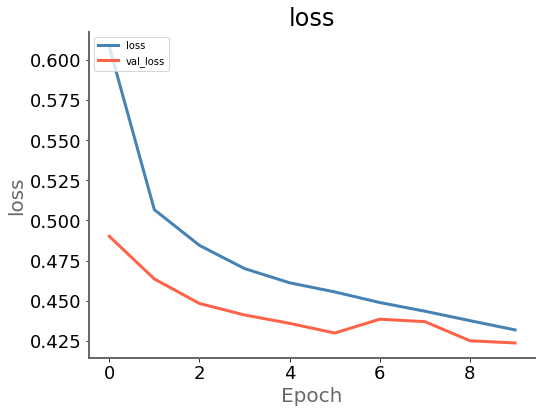

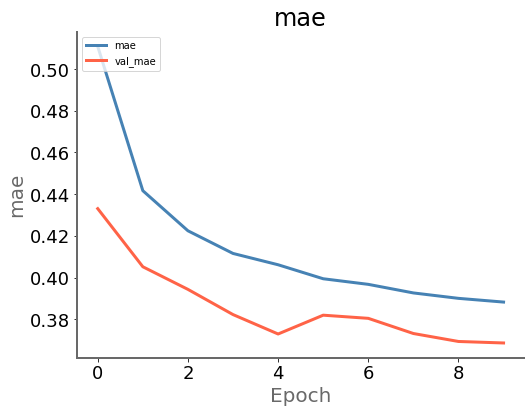

In [10]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

## Step 5 - Predict

### 5.1 - Load model

In [11]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

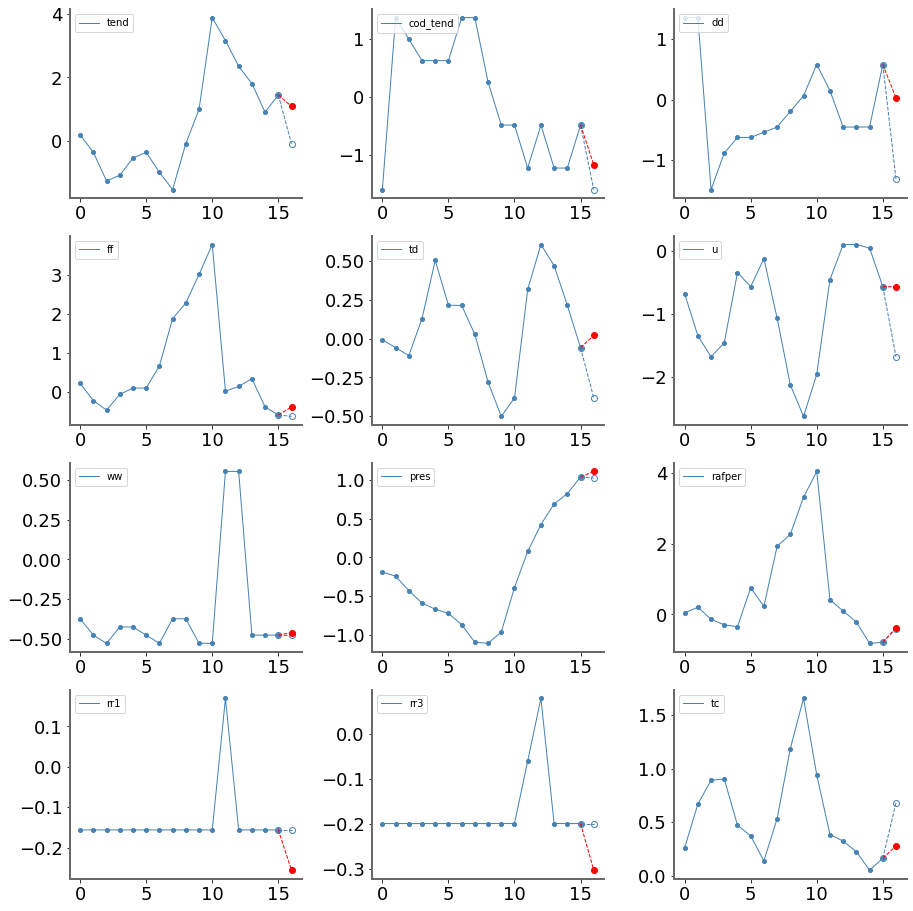

In [12]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

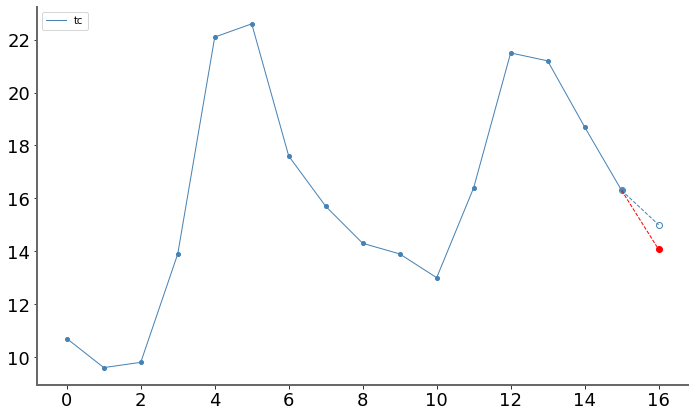

Gap between prediction and reality : 0.93 °C


In [13]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


In [14]:
pwk.end()

End time is : Monday 01 March 2021, 20:32:23
Duration is : 00:02:15 133ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>